In [22]:
!pip uninstall -y mediapipe opencv-python opencv-python-headless numpy huggingface-hub

Found existing installation: mediapipe 0.10.21
Uninstalling mediapipe-0.10.21:
  Successfully uninstalled mediapipe-0.10.21
Found existing installation: opencv-python 4.11.0
error: uninstall-no-record-file

× Cannot uninstall opencv-python 4.11.0
╰─> The package's contents are unknown: no RECORD file was found for opencv-python.

hint: The package was installed by conda. You should check if it can uninstall the package.


In [3]:
!pip install numpy
!pip install mediapipe opencv-python
!pip install pandas tqdm huggingface-hub
!pip install hdbscan
!pip install ruptures
!pip install torchcodec
!pip install datasets
!pip install torch torchvision torchaudio torchcodec av


  Using cached mediapipe-0.10.21-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (9.7 kB)
  Using cached flatbuffers-25.9.23-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached jax-0.8.0-py3-none-any.whl.metadata (13 kB)
  Using cached jaxlib-0.8.0-cp312-cp312-manylinux_2_27_x86_64.whl.metadata (1.3 kB)
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached opencv_contrib_python-4.12.0.88-cp37-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (19 kB)
  Using cached protobuf-4.25.8-cp37-abi3-manylinux2014_x86_64.whl.metadata (541 bytes)
  Using cached sounddevice-0.5.3-py3-none-any.whl.metadata (1.6 kB)
  Using cached sentencepiece-0.2.1-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (10 kB)
  Using cached ml_dtypes-0.5.3-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (8.9 kB)
INFO: pip is looking at multiple versions of jax to determine which version is compatible 

--------------------------------------------------------------------------------
# **Adaptive Keyframe + Regressive Generation Pipeline**
--------------------------------------------------------------------------------


In [4]:
# ============================================================
# Hybrid Adaptive Keyframe + Regressive Generation Pipeline
# STAGE 1: From raw video → ready ST-GCN input
# ============================================================

import os
import cv2
import json
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
import ruptures as rpt
import hdbscan
from tqdm import tqdm
import warnings

# Suppress warnings that clutter the output, like HDBSCAN convergence issues
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

AttributeError: 'numpy.dtypes.BoolDType' object has no attribute 'bits'

In [22]:
!pip uninstall -y pyarrow datasets pandas
!pip install --no-cache-dir --force-reinstall "pyarrow==17.0.0" "pandas==2.2.2" "datasets==3.0.1"


Found existing installation: pyarrow 17.0.0
Uninstalling pyarrow-17.0.0:
  Successfully uninstalled pyarrow-17.0.0
Found existing installation: datasets 3.0.1
Uninstalling datasets-3.0.1:
  Successfully uninstalled datasets-3.0.1
Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 199.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 187.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 600.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 622.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 288.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 807.9/807.9 kB 622.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install huggingface-hub opencv-python mediapipe tqdm --quiet


In [ ]:
import cv2
import numpy as np
import os
from tqdm import tqdm

# Path to local dataset on Saturn Cloud
DATA_DIR = "/home/jovyan/data/raw_videos"
MAX_VIDEOS = 15

# Recursively find all video files
all_files = []
for root, dirs, files in os.walk(DATA_DIR):
    for f in files:
        if f.lower().endswith(('.mp4', '.mov', '.avi', '.mkv', '.webm')):
            all_files.append(os.path.join(root, f))

print(f"Found {len(all_files)} video files in local folder: {DATA_DIR}")

# Limit to first N
selected_files = all_files[:MAX_VIDEOS]
print(f"📦 Loading first {len(selected_files)} videos...")

videos = []
for file_path in tqdm(selected_files, desc="Loading local videos"):
    cap = cv2.VideoCapture(file_path)
    frames = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        # Convert BGR → RGB for ML processing
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame_rgb)
    cap.release()

    frames = np.array(frames)
    videos.append(frames)
    print(f"✅ Loaded {os.path.basename(file_path)}: {frames.shape}")

print(f"\n🎬 Total videos loaded: {len(videos)}")


Found 162 video files in local folder: /home/jovyan/data/raw_videos
📦 Loading first 15 videos...


Loading local videos:   7%|▋         | 1/15 [00:27<06:24, 27.49s/it]

✅ Loaded Thattadavu1.3.mp4: (1850, 1080, 1920, 3)


Loading local videos:  13%|█▎        | 2/15 [00:52<05:35, 25.79s/it]

✅ Loaded Thattadavu1.5.mp4: (1650, 1080, 1920, 3)


Loading local videos:  20%|██        | 3/15 [01:10<04:29, 22.49s/it]

✅ Loaded ThathaiThaha1.3.mp4: (1275, 1080, 1920, 3)


In [26]:
import mediapipe as mp
import numpy as np
import cv2

def extract_poses_from_array(frames, fps_real=30, fps_target=4, conf_thresh=0.3, out_dir=None):
    """
    frames: list or np.array of RGB frames (H, W, 3)
    fps_real: actual frame rate of the source video
    fps_target: sampling frequency for pose extraction
    """
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose(static_image_mode=False, model_complexity=1)

    # Compute sampling interval
    frame_interval = int(round(fps_real / fps_target))
    poses, confs, times = [], [], []
    t = 0.0

    for frame_id, frame in enumerate(frames):
        if frame_id % frame_interval != 0:
            continue

        # Ensure frame is RGB float32 for MediaPipe
        if frame.dtype != np.uint8:
            frame = np.clip(frame, 0, 255).astype(np.uint8)

        results = pose.process(frame)

        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark
            pose_xy = np.array([[lm.x, lm.y] for lm in landmarks])
            conf = np.array([lm.visibility for lm in landmarks])
        else:
            pose_xy = np.zeros((33, 2))
            conf = np.zeros((33,))

        poses.append(pose_xy)
        confs.append(conf)
        times.append(t)
        t += 1.0 / fps_target

    poses = np.array(poses)
    confs = np.array(confs)
    times = np.array(times)

    # === Visibility-based interpolation ===
    poses_filtered = poses.copy()
    for j in range(poses.shape[1]):
        low = confs[:, j] < conf_thresh
        if np.any(low):
            good_idx = np.where(~low)[0]
            if len(good_idx) >= 2:
                poses_filtered[:, j, 0] = np.interp(np.arange(len(poses)), good_idx, poses[good_idx, j, 0])
                poses_filtered[:, j, 1] = np.interp(np.arange(len(poses)), good_idx, poses[good_idx, j, 1])

    pose.close()
    return poses_filtered, confs, times


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os

def normalize_and_compute_features(poses, confs, times, out_dir=None, fps_target=4):
    """
    Normalize pose coordinates and compute velocity-based dynamic features.
    
    Args:
        poses: np.ndarray [T, J, 2]  – 2D keypoints over time
        confs: np.ndarray [T, J]     – visibility/confidence per keypoint
        times: np.ndarray [T]        – frame timestamps
        out_dir: Optional path for visualization output
        fps_target: Used if 'times' has <2 samples to estimate dt
    """
    # ---- Safety checks ----
    if poses.ndim != 3 or poses.shape[2] != 2:
        raise ValueError("poses must be of shape [T, J, 2]")
    if confs.shape[:2] != poses.shape[:2]:
        raise ValueError("confs must match poses in first 2 dims")

    # ---- Parameters ----
    root_idx = 24  # Pelvis landmark index (MediaPipe)
    dt = np.mean(np.diff(times)) if len(times) > 1 else 1.0 / fps_target

    # ---- Root centering ----
    root = poses[:, root_idx:root_idx+1, :]  # shape [T, 1, 2]
    poses_centered = poses - root

    # ---- Scale normalization using shoulder distance ----
    L_torso = np.linalg.norm(poses[:, 11, :] - poses[:, 12, :], axis=1, keepdims=True)
    L_torso[L_torso == 0] = 1e-6  # prevent division by zero
    poses_norm = poses_centered / L_torso[:, None, :]

    # ---- Velocity (Δpose / Δt) ----
    v = np.zeros_like(poses_norm)
    v[1:] = (poses_norm[1:] - poses_norm[:-1]) / dt
    v[0] = v[1]  # copy first value to avoid zeroing initial motion

    # ---- Feature tensor ----
    features = np.concatenate([poses_norm, v, confs[..., None]], axis=-1)  # [T, J, 5]

    # ---- Visualization (optional) ----
    if out_dir and len(poses) > 10:
        os.makedirs(out_dir, exist_ok=True)
        j_ex = 16  # Right wrist example joint

        plt.figure(figsize=(14, 5))

        # Subplot 1: Spatial normalization
        plt.subplot(1, 2, 1)
        plt.plot(poses[:, j_ex, 0], poses[:, j_ex, 1],
                 label='Raw Coords (Camera-Dependent)', alpha=0.7)
        plt.plot(poses_norm[:, j_ex, 0], poses_norm[:, j_ex, 1],
                 label='Normalized Coords (Invariant)',
                 linestyle='--', color='red')
        plt.title(f'C. Pose Normalization (Joint {j_ex})')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.legend(loc='upper right')
        plt.gca().set_aspect('equal', adjustable='box')
        plt.grid(True, alpha=0.3)

        # Subplot 2: Velocity magnitude
        plt.subplot(1, 2, 2)
        v_mag = np.linalg.norm(v[:, j_ex, :], axis=1)
        plt.plot(v_mag, label=f'Joint {j_ex} Velocity', color='green', linewidth=2)
        plt.title('Velocity Magnitude (Dynamic Feature)')
        plt.xlabel('Frame Index')
        plt.ylabel('Velocity (a.u.)')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()
       

    return poses_norm, features


AttributeError: 'numpy.dtypes.BoolDType' object has no attribute 'bits'

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
import ruptures as rpt
import hdbscan
import os

def compute_frame_speed(poses_norm, times):
    """Compute mean joint speed per frame (motion energy)."""
    v = np.diff(poses_norm, axis=0)
    speed = np.linalg.norm(v, axis=-1).mean(axis=1)  # mean joint speed across joints
    return np.concatenate([[speed[0]], speed])  # align length with frames


def detect_keyframes(
    poses_norm,
    times,
    out_dir=None,
    gaussian_sigma=2.0,
    peak_alpha=1.5,
    min_peak_distance=5,
    ruptures_penalty=20,
    min_cluster_size=10,
    merge_window=3,
    transition_window=2
):
    """
    Adaptive Keyframe Selection using:
      1. Velocity Peaks (motion-based)
      2. Change Point Detection (ruptures)
      3. Pose Density Clustering (HDBSCAN)
    
    Combines all three sources and merges temporally close detections.
    """

    T = len(poses_norm)
    if T < 3:
        return list(range(T)), None  # too few frames to analyze

    # 1️⃣ Compute smoothed motion energy
    speed = compute_frame_speed(poses_norm, times)
    speed_sm = gaussian_filter1d(speed, sigma=gaussian_sigma)

    # 2️⃣ Velocity-based peaks
    mu, sigma = np.mean(speed_sm), np.std(speed_sm)
    peaks, _ = find_peaks(
        speed_sm,
        height=mu + peak_alpha * sigma,
        distance=min_peak_distance
    )

    # 3️⃣ Change-point detection (ruptures)
    z = poses_norm.reshape(T, -1)
    algo = rpt.Pelt(model="rbf").fit(z)
    cps = np.array(algo.predict(pen=ruptures_penalty)[:-1])

    # 4️⃣ Density clustering (HDBSCAN)
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
    labels = clusterer.fit_predict(z)

    medoids = []
    for lbl in np.unique(labels):
        if lbl == -1:  # noise cluster
            continue
        idxs = np.where(labels == lbl)[0]
        med = idxs[len(idxs)//2]  # middle frame as cluster representative
        medoids.append(med)
    medoids = np.array(medoids)

    # 5️⃣ Fusion of all detections
    candidates = np.unique(np.concatenate([peaks, cps, medoids]))
    candidates = np.clip(candidates, 0, T - 1)
    candidates = np.sort(candidates)

    # 6️⃣ Merge close detections
    merged = []
    if len(candidates) > 0:
        merged.append(candidates[0])
        for k in candidates[1:]:
            if k - merged[-1] > merge_window:
                merged.append(k)
            else:
                merged[-1] = int((merged[-1] + k) / 2)

    # 7️⃣ Expand transition windows
    final_idxs = []
    for k in merged:
        start = max(0, k - transition_window)
        end = min(T, k + transition_window + 1)
        final_idxs.extend(range(start, end))
    keyframes = sorted(list(set(final_idxs)))

    # 🔍 Visualizations
    if out_dir and T > 10:
        os.makedirs(out_dir, exist_ok=True)

        # --- Visualization D: Fusion summary ---
        plt.figure(figsize=(12, 6))
        plt.plot(speed_sm, label='Smoothed Mean Joint Speed ($|v|$)', color='blue')
        plt.scatter(peaks, speed_sm[peaks], marker='o', color='red', s=50, label='1. Velocity Peaks')
        plt.scatter(cps, speed_sm[cps.clip(0, T-1)], marker='^', color='orange', s=50, label='2. Change Points')
        plt.scatter(medoids, speed_sm[medoids.clip(0, T-1)], marker='s', color='green', s=50, label='3. Cluster Medoids')
        plt.scatter(keyframes, speed_sm[keyframes], marker='|', color='black', s=100, label=f'Final Keyframes (N={len(keyframes)})', alpha=0.6)
        plt.title('D. Adaptive Keyframe Selection: 3-Way Fusion')
        plt.xlabel('Frame Index')
        plt.ylabel('Motion Speed (a.u.)')
        plt.legend(loc='upper right')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        # plt.savefig(os.path.join(out_dir, "viz_D_keyframe_fusion_summary.png"))
        plt.show()

        # --- Visualization A: Smoothing effect ---
        plt.figure(figsize=(12, 5))
        plt.plot(speed, label='Raw Mean Joint Speed', alpha=0.4, color='gray')
        plt.plot(speed_sm, label=fr'Smoothed Speed ($σ$={gaussian_sigma})', color='blue', linewidth=2)
        plt.scatter(peaks, speed_sm[peaks], marker='o', color='red', s=50, label='Detected Velocity Peaks')
        plt.axhline(y=mu + peak_alpha * sigma, color='red', linestyle='--', alpha=0.6, label='Peak Threshold')
        plt.title('A. Motion Energy: Raw vs Smoothed Speed')
        plt.xlabel('Frame Index')
        plt.ylabel('Normalized Motion Speed')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        # plt.savefig(os.path.join(out_dir, "viz_A_speed_smoothing.png"))
        # plt.close()

    return keyframes, speed_sm


Found 162 video files in /home/jovyan/data/raw_videos


Loading videos: 100%|██████████| 15/15 [00:40<00:00,  2.72s/it]


📦 Loaded 15 videos. Starting processing...


Processing videos:   0%|          | 0/15 [00:00<?, ?it/s]INFO: Created TensorFlow Lite XNNPACK delegate for CPU.



▶ Processing Thattadavu1.3.mp4


W0000 00:00:1761489231.028359   16145 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1761489231.052133   16145 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1761489231.110425   16158 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


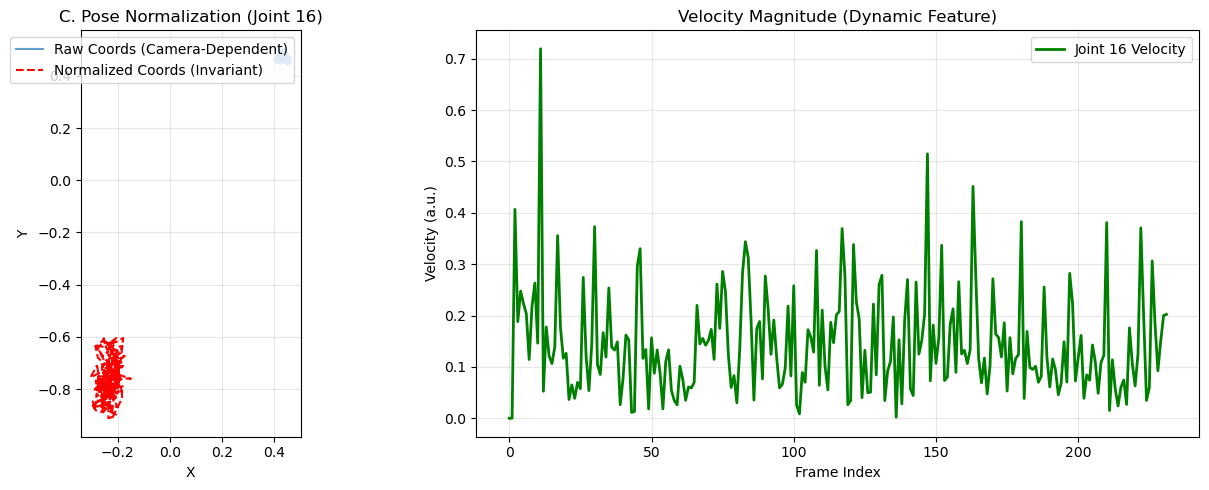

Traceback (most recent call last):
  File "/tmp/ipykernel_6725/3698835131.py", line 118, in process_video
    keyframes, speed_sm = detect_keyframes(
                          ^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_6725/400828548.py", line 91, in detect_keyframes
    final_idxs.extend(range(start, end))
                      ^^^^^^^^^^^^^^^^^
TypeError: 'numpy.float64' object cannot be interpreted as an integer
Processing videos:   7%|▋         | 1/15 [00:16<03:51, 16.52s/it]

❌ Error processing video Thattadavu1.3.mp4: 'numpy.float64' object cannot be interpreted as an integer

▶ Processing Thattadavu1.5.mp4


W0000 00:00:1761489247.413729   16231 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1761489247.443326   16249 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


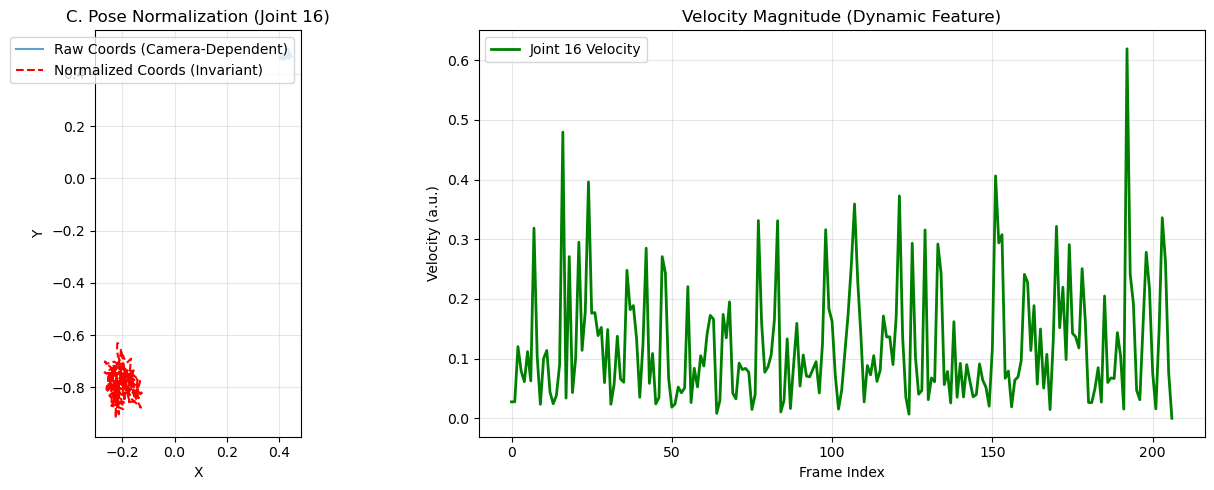

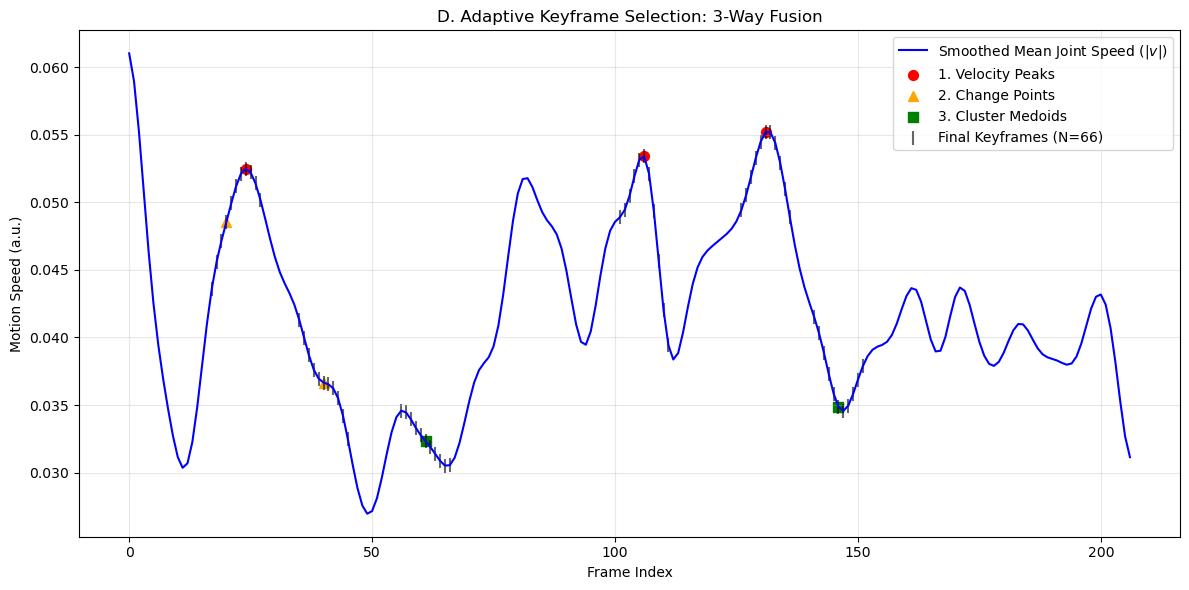

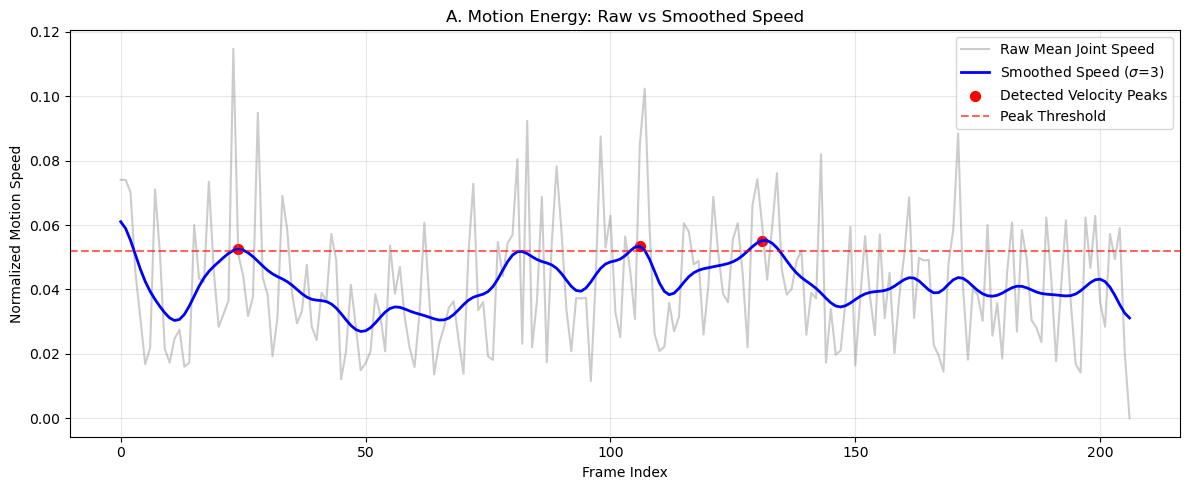

Processing videos:  13%|█▎        | 2/15 [00:31<03:22, 15.56s/it]

✅ Saved 66 keyframes → /home/jovyan/data/processed/Thattadavu1.5.mp4

▶ Processing ThathaiThaha1.3.mp4


W0000 00:00:1761489262.313366   16320 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1761489262.345818   16341 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


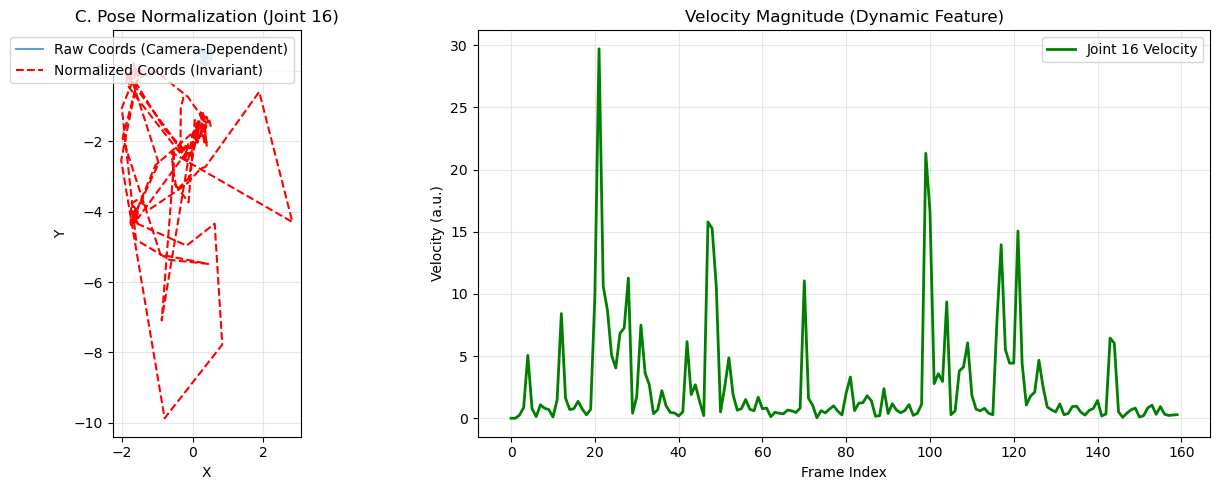

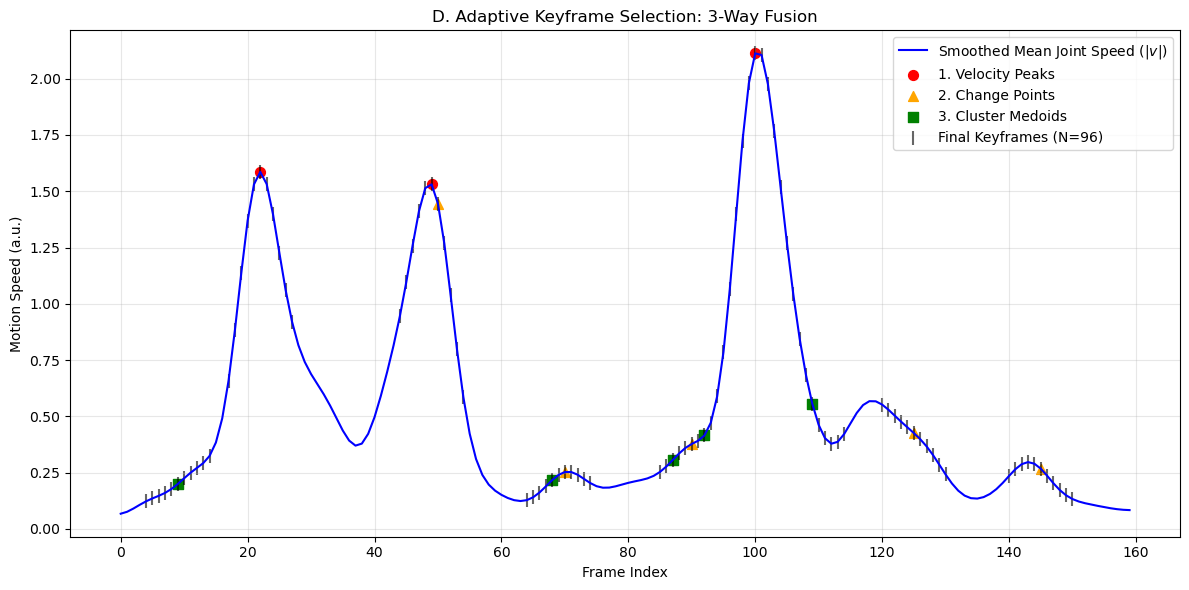

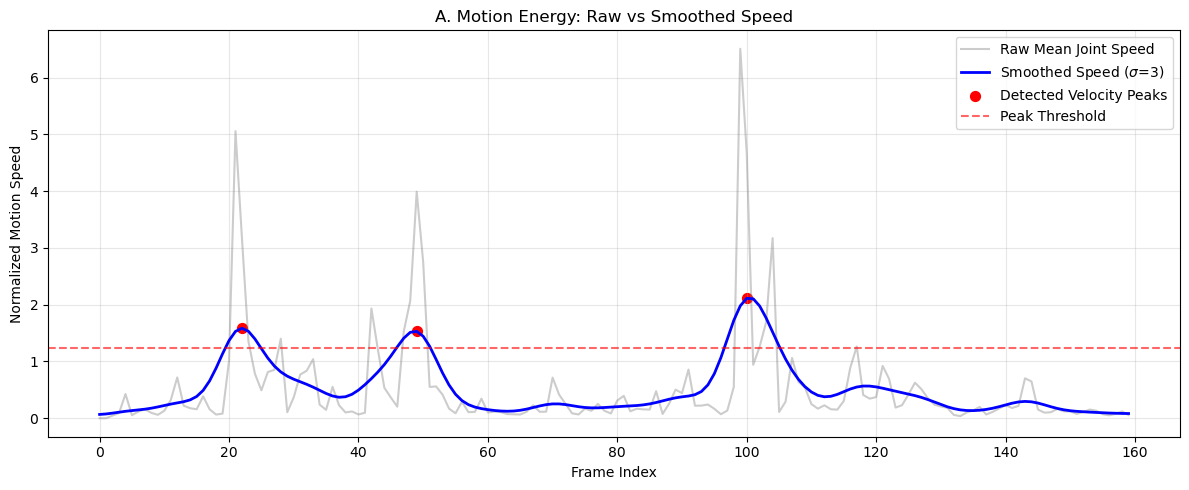

Processing videos:  20%|██        | 3/15 [00:42<02:40, 13.38s/it]

✅ Saved 96 keyframes → /home/jovyan/data/processed/ThathaiThaha1.3.mp4

▶ Processing SarukkalAdavu2.1.mp4


W0000 00:00:1761489273.041809   16395 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1761489273.116747   16413 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


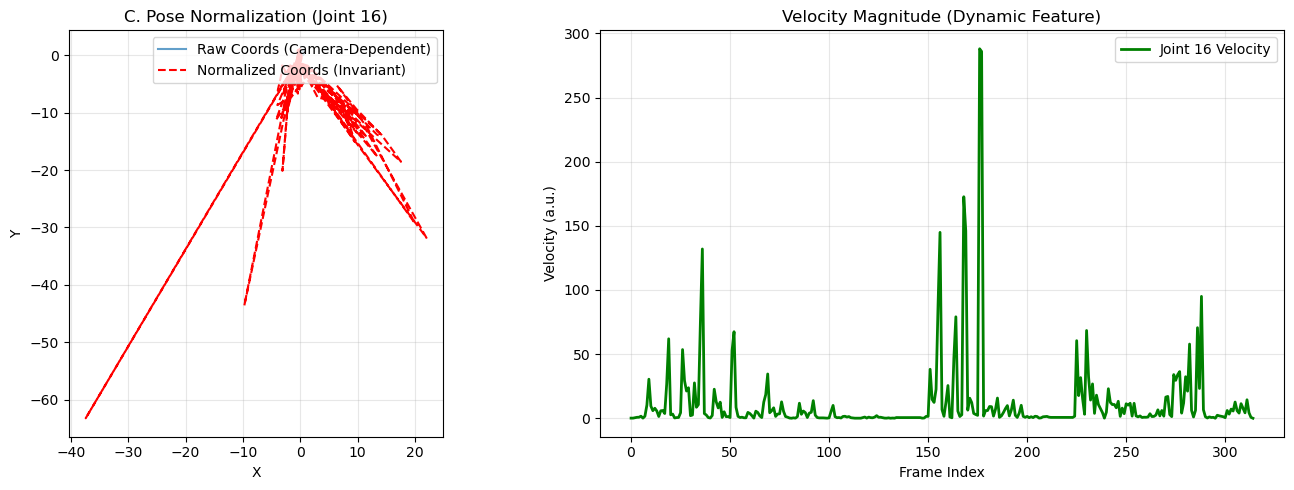

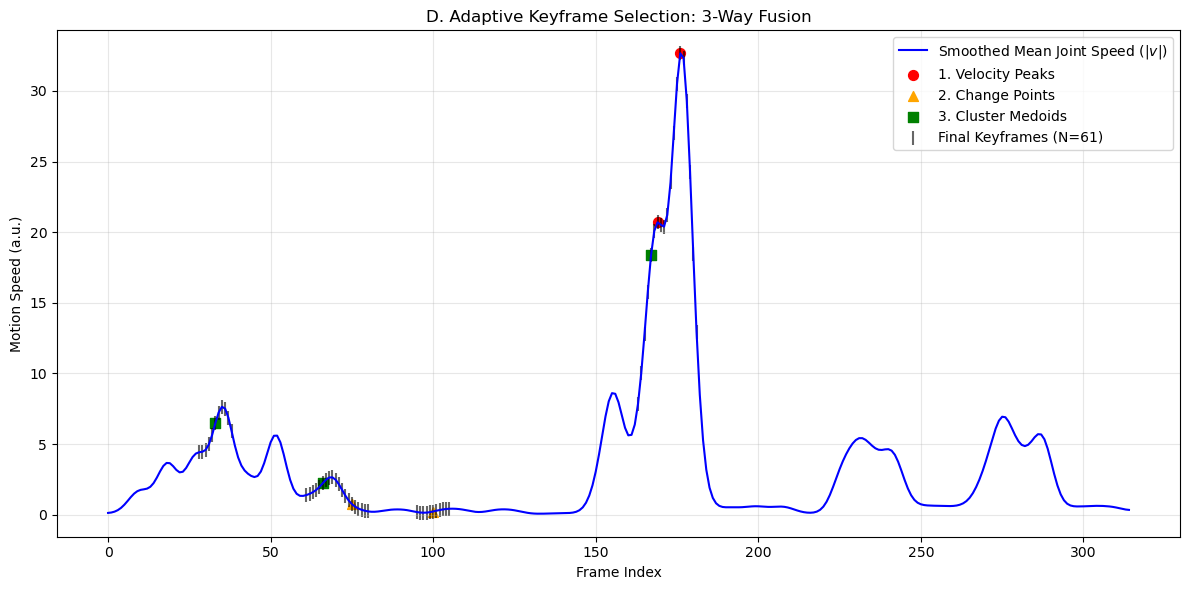

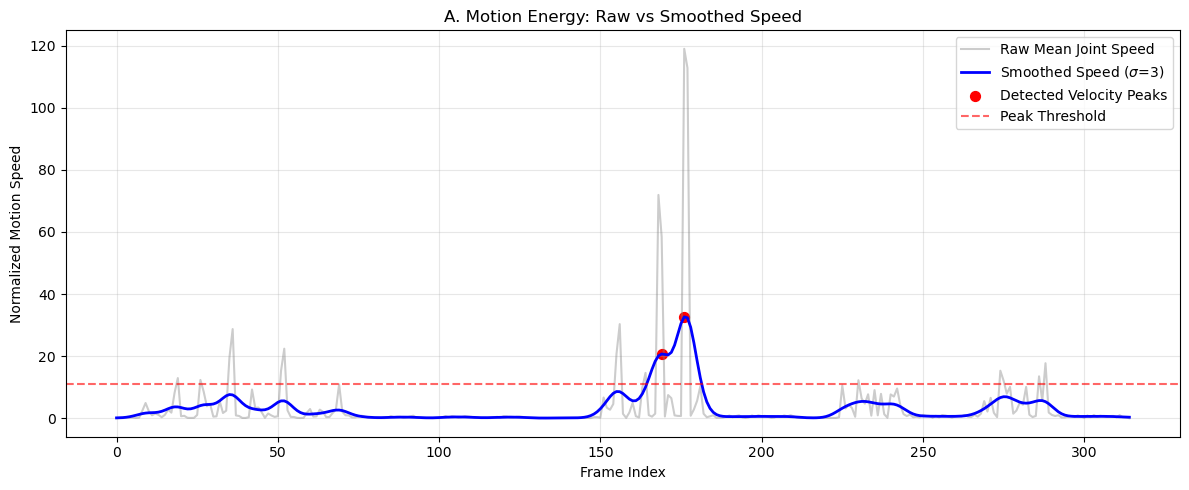

Processing videos:  27%|██▋       | 4/15 [01:04<03:07, 17.00s/it]

✅ Saved 61 keyframes → /home/jovyan/data/processed/SarukkalAdavu2.1.mp4

▶ Processing ThattiMettuAdavu4.1.mp4


W0000 00:00:1761489295.606727   16481 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1761489295.645861   16500 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


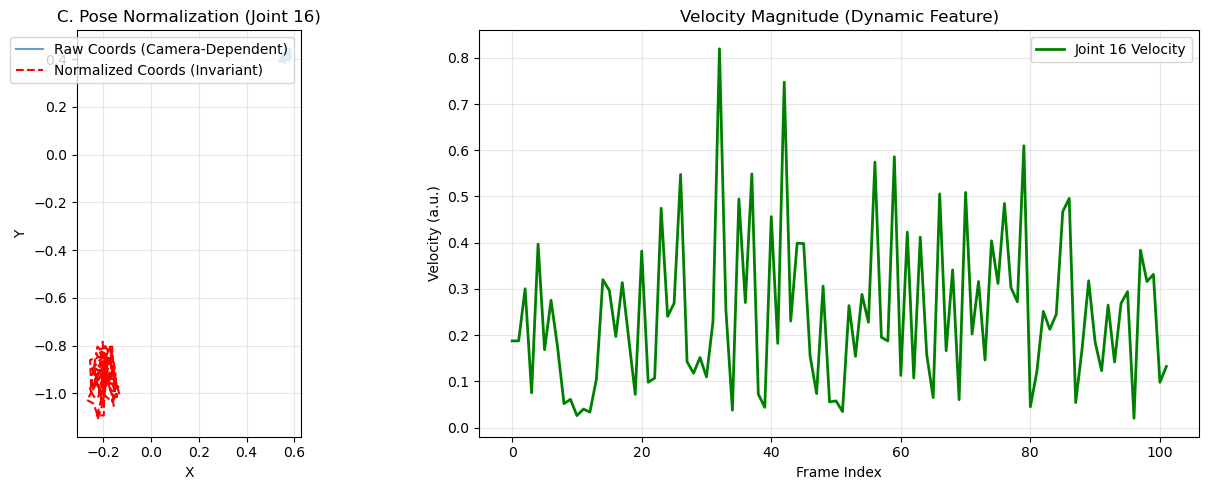

Traceback (most recent call last):
  File "/tmp/ipykernel_6725/3698835131.py", line 118, in process_video
    keyframes, speed_sm = detect_keyframes(
                          ^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_6725/400828548.py", line 91, in detect_keyframes
    final_idxs.extend(range(start, end))
                      ^^^^^^^^^^^^^^^^^
TypeError: 'numpy.float64' object cannot be interpreted as an integer
Processing videos:  33%|███▎      | 5/15 [01:13<02:19, 13.90s/it]

❌ Error processing video ThattiMettuAdavu4.1.mp4: 'numpy.float64' object cannot be interpreted as an integer

▶ Processing THATTIMETTUADAVU1.2.mp4


W0000 00:00:1761489304.008708   16561 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1761489304.035908   16579 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


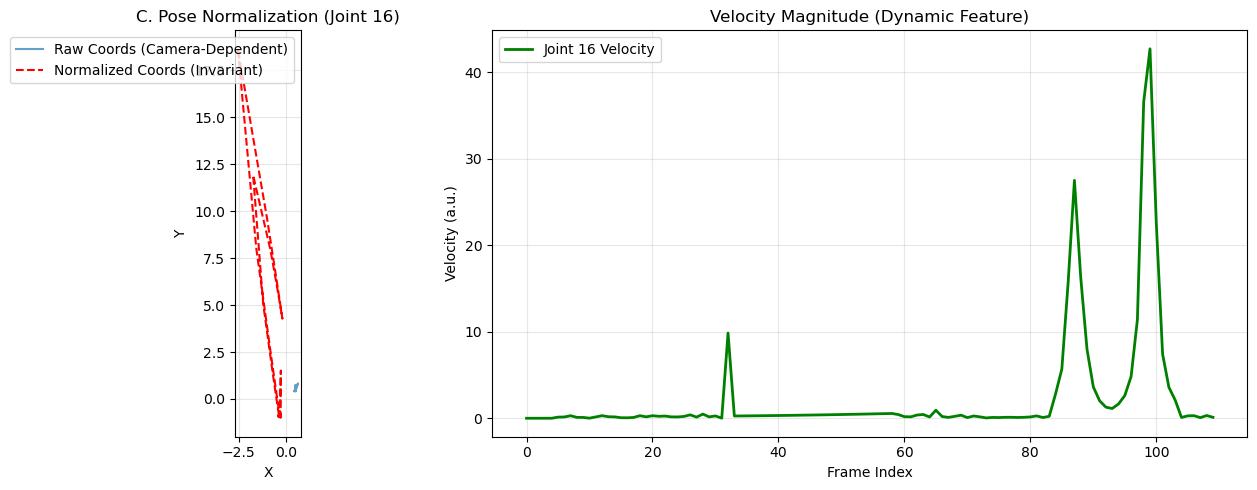

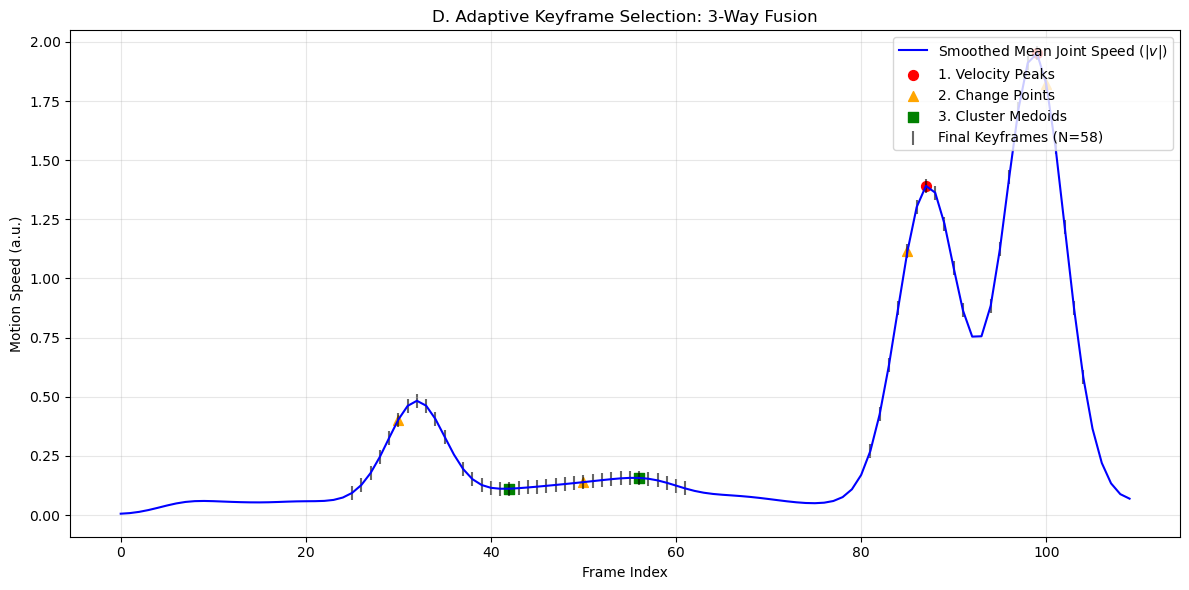

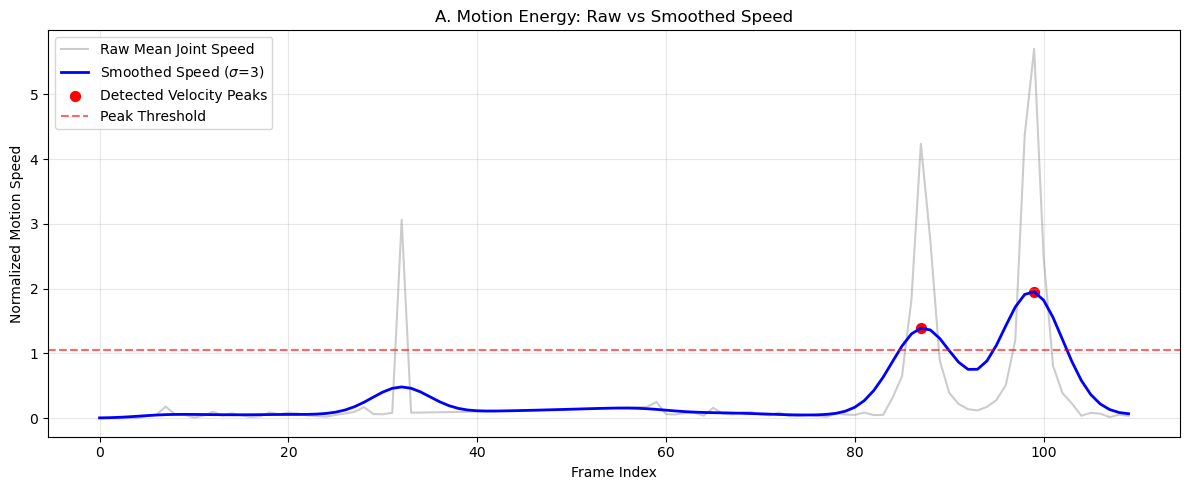

Processing videos:  40%|████      | 6/15 [01:21<01:48, 12.06s/it]

✅ Saved 58 keyframes → /home/jovyan/data/processed/THATTIMETTUADAVU1.2.mp4

▶ Processing Thattadavu1.mp4


W0000 00:00:1761489312.509397   16639 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1761489312.540584   16659 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


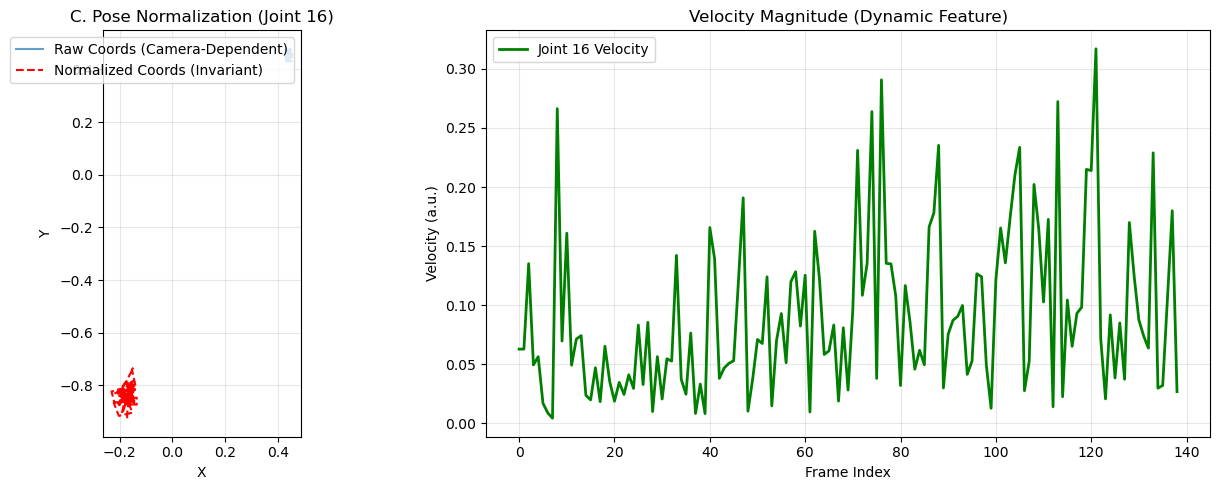

Traceback (most recent call last):
  File "/tmp/ipykernel_6725/3698835131.py", line 118, in process_video
    keyframes, speed_sm = detect_keyframes(
                          ^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_6725/400828548.py", line 91, in detect_keyframes
    final_idxs.extend(range(start, end))
                      ^^^^^^^^^^^^^^^^^
TypeError: 'numpy.float64' object cannot be interpreted as an integer
Processing videos:  47%|████▋     | 7/15 [01:31<01:30, 11.32s/it]

❌ Error processing video Thattadavu1.mp4: 'numpy.float64' object cannot be interpreted as an integer

▶ Processing Nattadavu4.mp4


W0000 00:00:1761489322.289682   16717 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1761489322.314972   16738 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


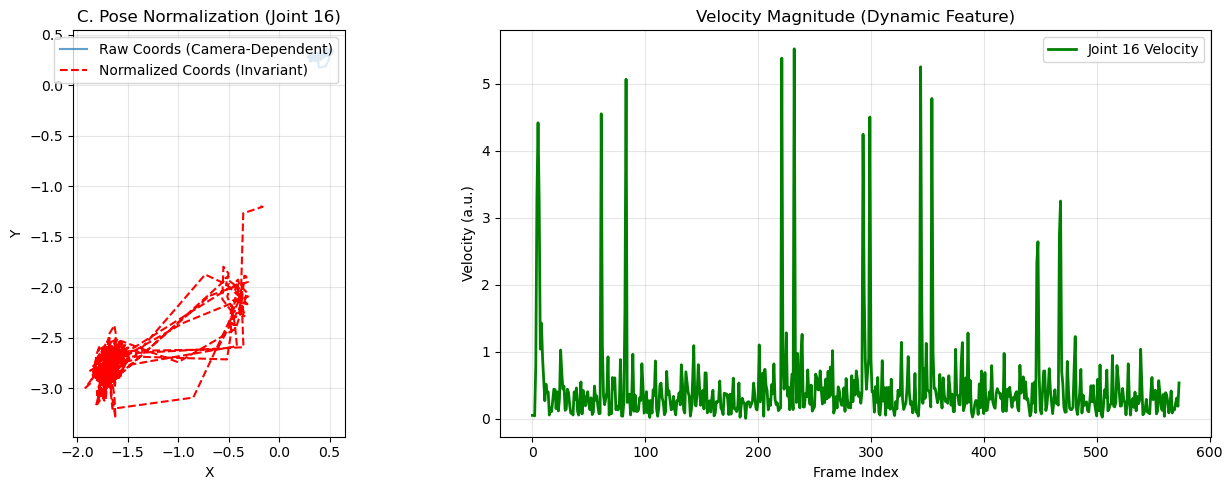

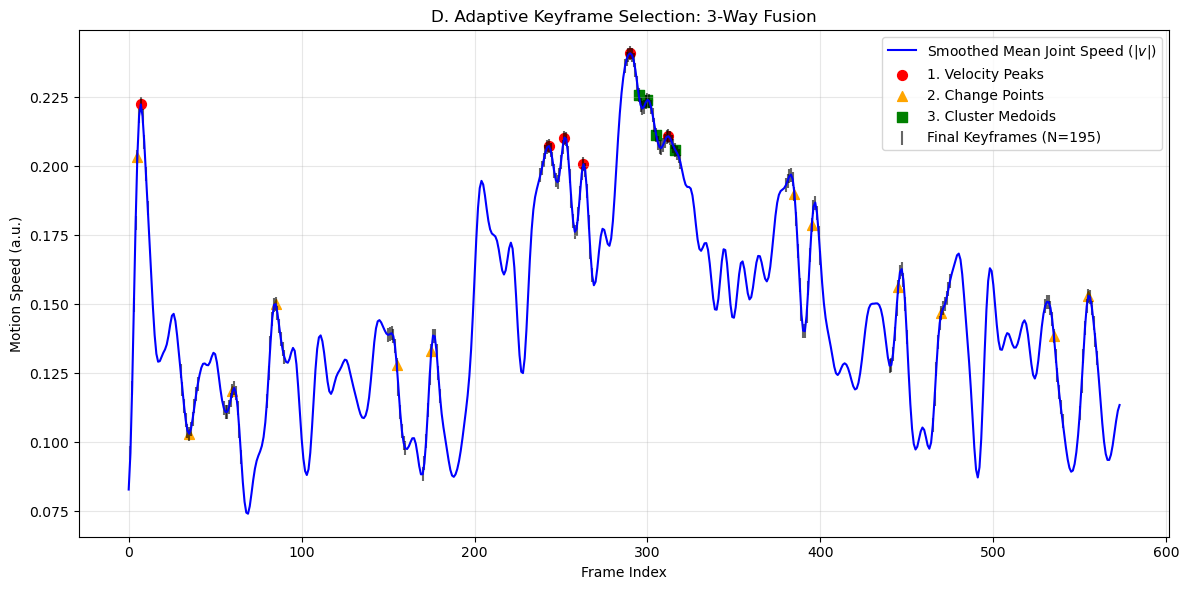

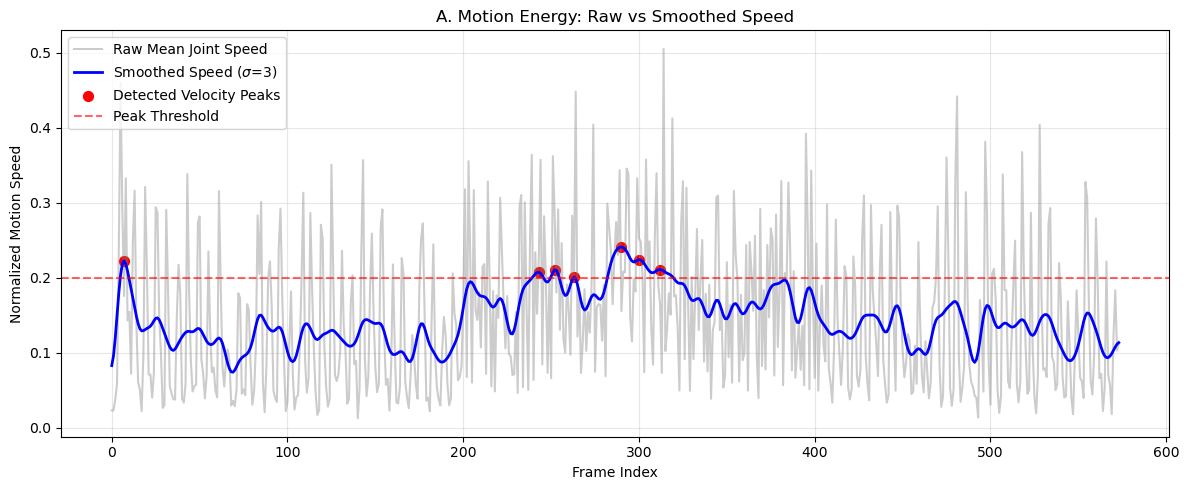

Processing videos:  53%|█████▎    | 8/15 [02:12<02:24, 20.68s/it]

✅ Saved 195 keyframes → /home/jovyan/data/processed/Nattadavu4.mp4

▶ Processing ThattimettuAdavu2.mp4


W0000 00:00:1761489363.015337   16834 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1761489363.044942   16854 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


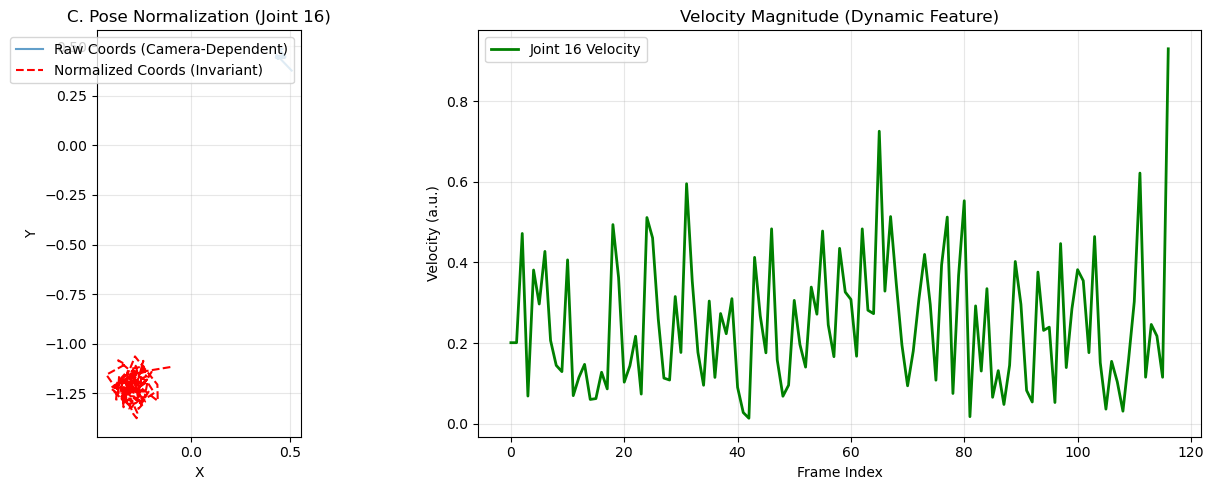

Traceback (most recent call last):
  File "/tmp/ipykernel_6725/3698835131.py", line 118, in process_video
    keyframes, speed_sm = detect_keyframes(
                          ^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_6725/400828548.py", line 91, in detect_keyframes
    final_idxs.extend(range(start, end))
                      ^^^^^^^^^^^^^^^^^
TypeError: 'numpy.float64' object cannot be interpreted as an integer
Processing videos:  60%|██████    | 9/15 [02:20<01:40, 16.68s/it]

❌ Error processing video ThattimettuAdavu2.mp4: 'numpy.float64' object cannot be interpreted as an integer

▶ Processing Thattadavu2.5.mp4


W0000 00:00:1761489370.886525   16902 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1761489370.909360   16930 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


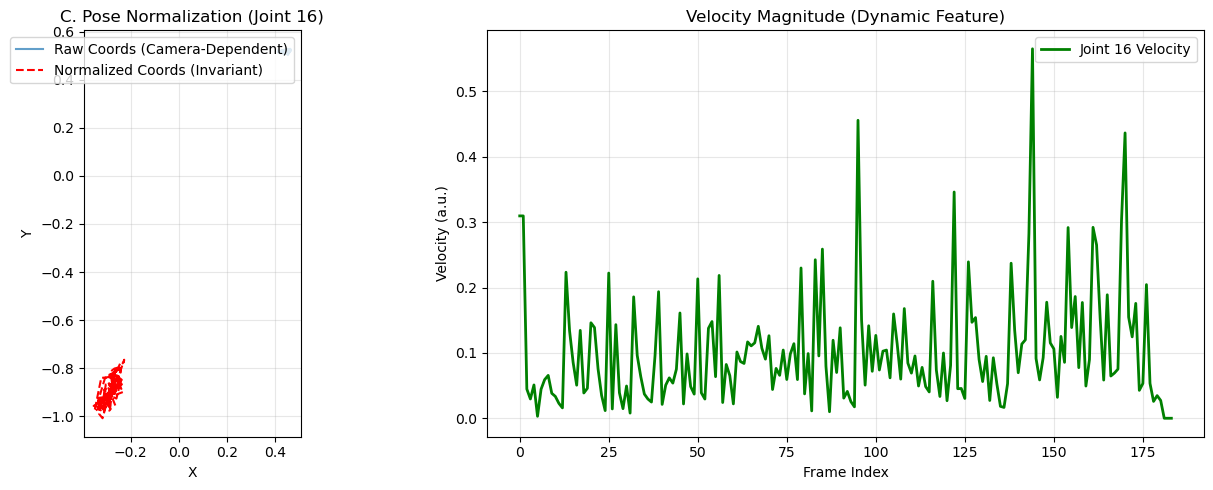

Traceback (most recent call last):
  File "/tmp/ipykernel_6725/3698835131.py", line 118, in process_video
    keyframes, speed_sm = detect_keyframes(
                          ^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_6725/400828548.py", line 91, in detect_keyframes
    final_idxs.extend(range(start, end))
                      ^^^^^^^^^^^^^^^^^
TypeError: 'numpy.float64' object cannot be interpreted as an integer
Processing videos:  67%|██████▋   | 10/15 [02:31<01:15, 15.17s/it]

❌ Error processing video Thattadavu2.5.mp4: 'numpy.float64' object cannot be interpreted as an integer

▶ Processing ThaThaiThaHa5.mp4


W0000 00:00:1761489382.708286   16983 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1761489382.737295   17004 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


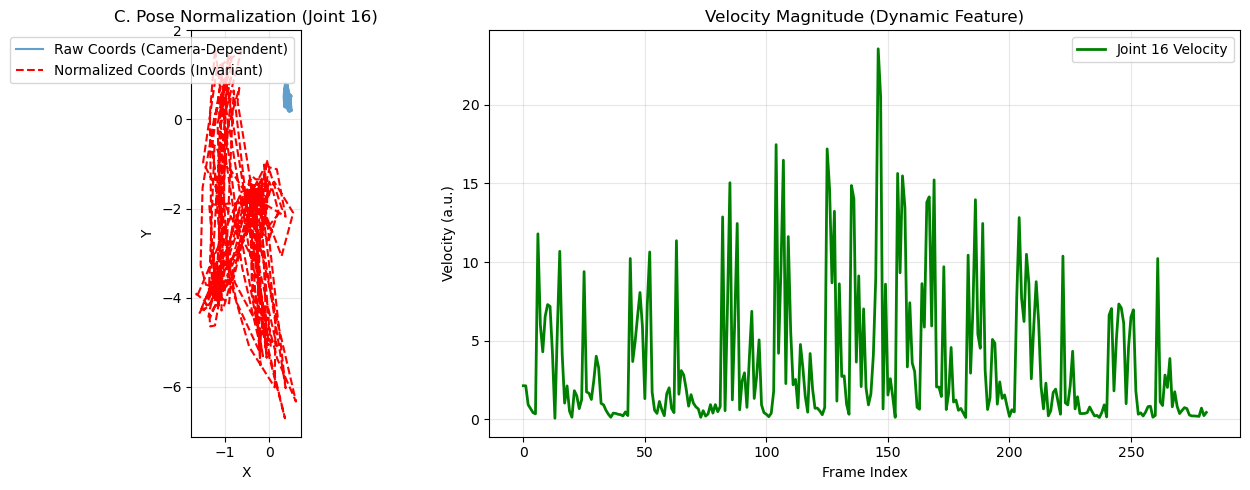

Traceback (most recent call last):
  File "/tmp/ipykernel_6725/3698835131.py", line 118, in process_video
    keyframes, speed_sm = detect_keyframes(
                          ^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_6725/400828548.py", line 91, in detect_keyframes
    final_idxs.extend(range(start, end))
                      ^^^^^^^^^^^^^^^^^
TypeError: 'numpy.float64' object cannot be interpreted as an integer
Processing videos:  73%|███████▎  | 11/15 [02:50<01:05, 16.37s/it]

❌ Error processing video ThaThaiThaHa5.mp4: 'numpy.float64' object cannot be interpreted as an integer

▶ Processing THATTIMETTUADAVU1.1.mp4


W0000 00:00:1761489401.782320   17066 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1761489401.805912   17095 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


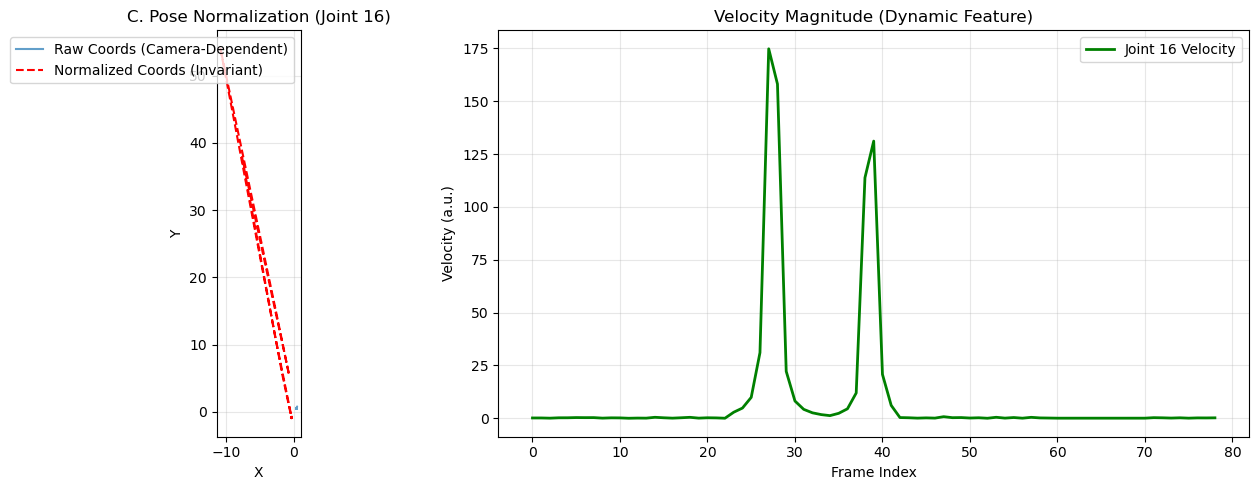

Traceback (most recent call last):
  File "/tmp/ipykernel_6725/3698835131.py", line 118, in process_video
    keyframes, speed_sm = detect_keyframes(
                          ^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_6725/400828548.py", line 103, in detect_keyframes
    plt.scatter(medoids, speed_sm[medoids.clip(0, T-1)], marker='s', color='green', s=50, label='3. Cluster Medoids')
                         ~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^
IndexError: arrays used as indices must be of integer (or boolean) type
Processing videos:  80%|████████  | 12/15 [02:55<00:37, 12.64s/it]

❌ Error processing video THATTIMETTUADAVU1.1.mp4: arrays used as indices must be of integer (or boolean) type

▶ Processing ThaiyaThaihi1.mp4


W0000 00:00:1761489405.874435   17141 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1761489405.898734   17169 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


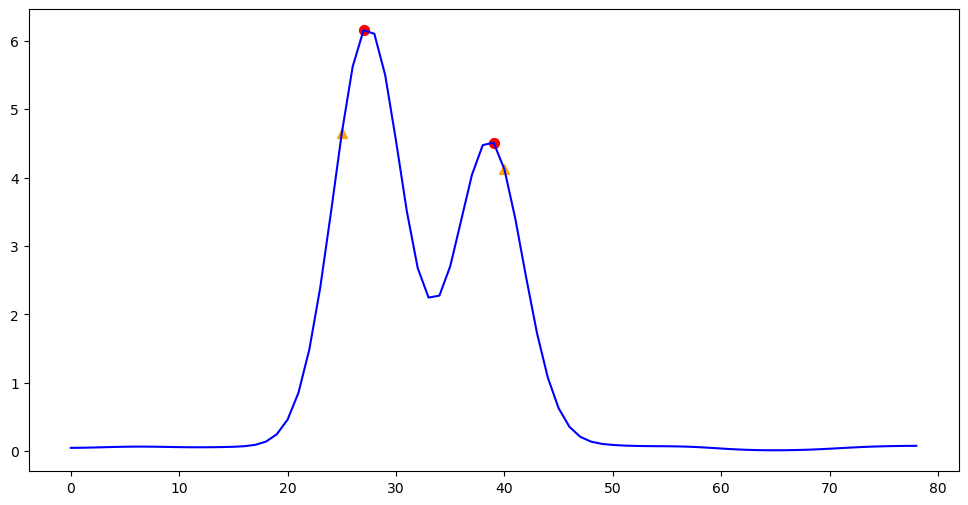

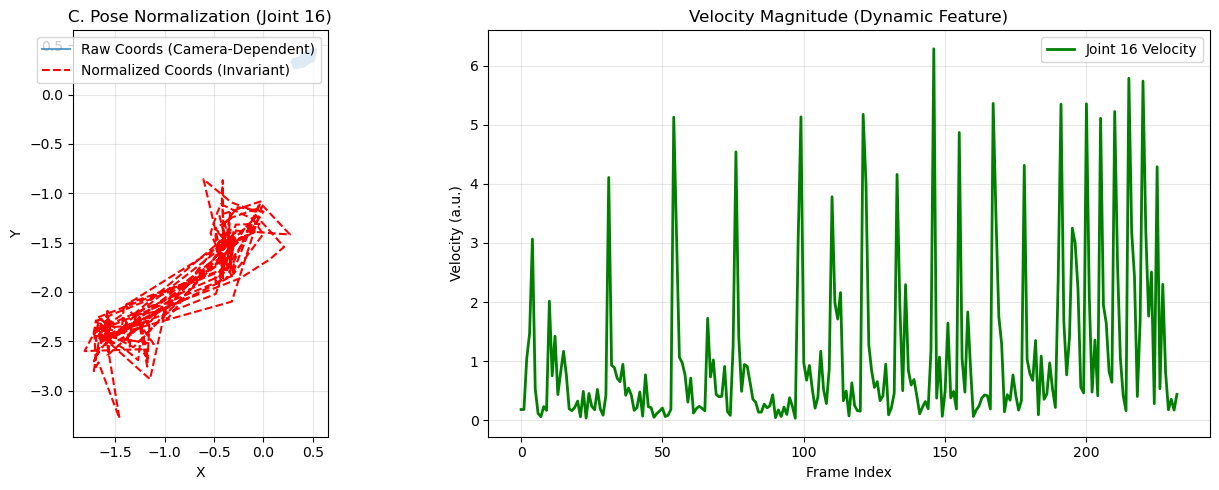

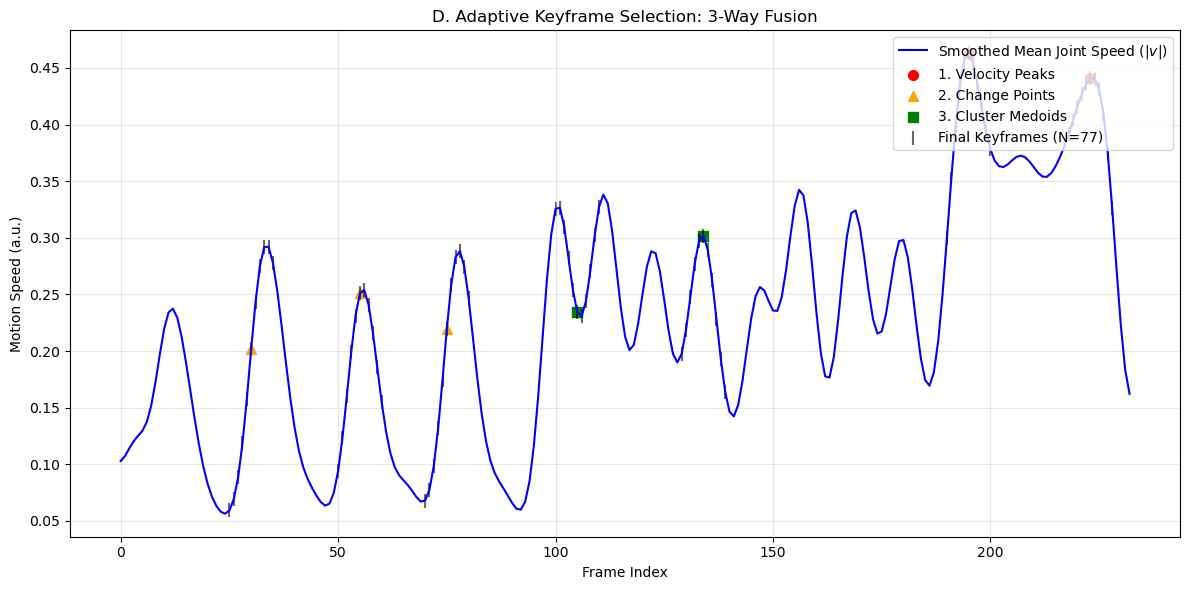

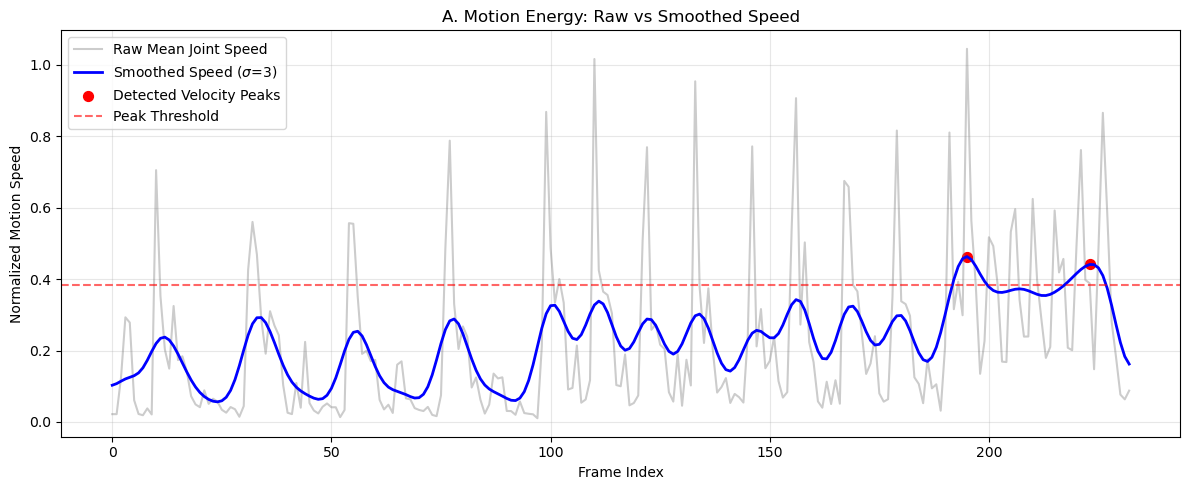

Processing videos:  87%|████████▋ | 13/15 [03:10<00:26, 13.48s/it]

✅ Saved 77 keyframes → /home/jovyan/data/processed/ThaiyaThaihi1.mp4

▶ Processing KorvaiAdavu2.mp4


W0000 00:00:1761489421.318677   17226 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1761489421.402216   17246 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


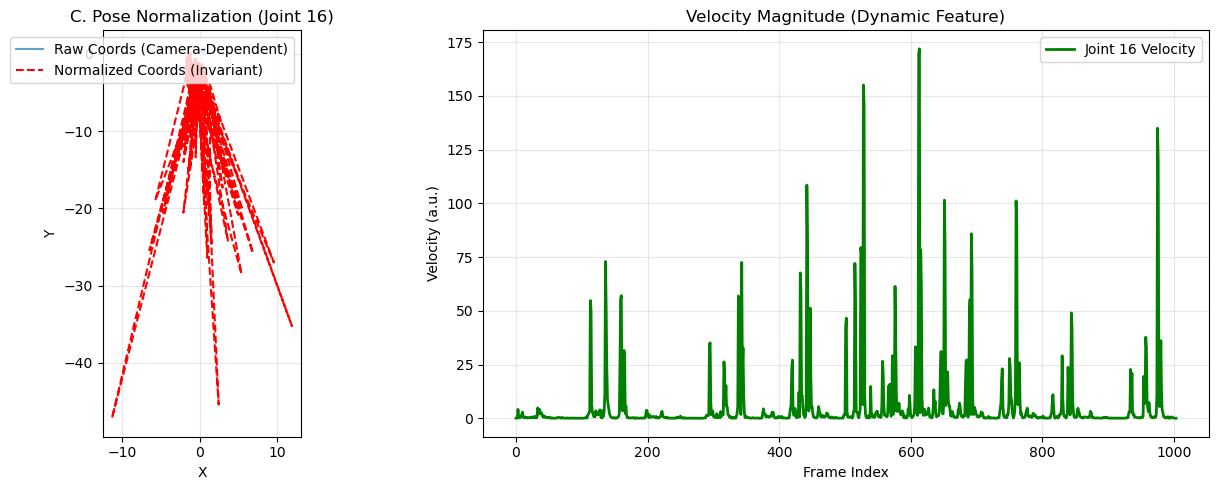

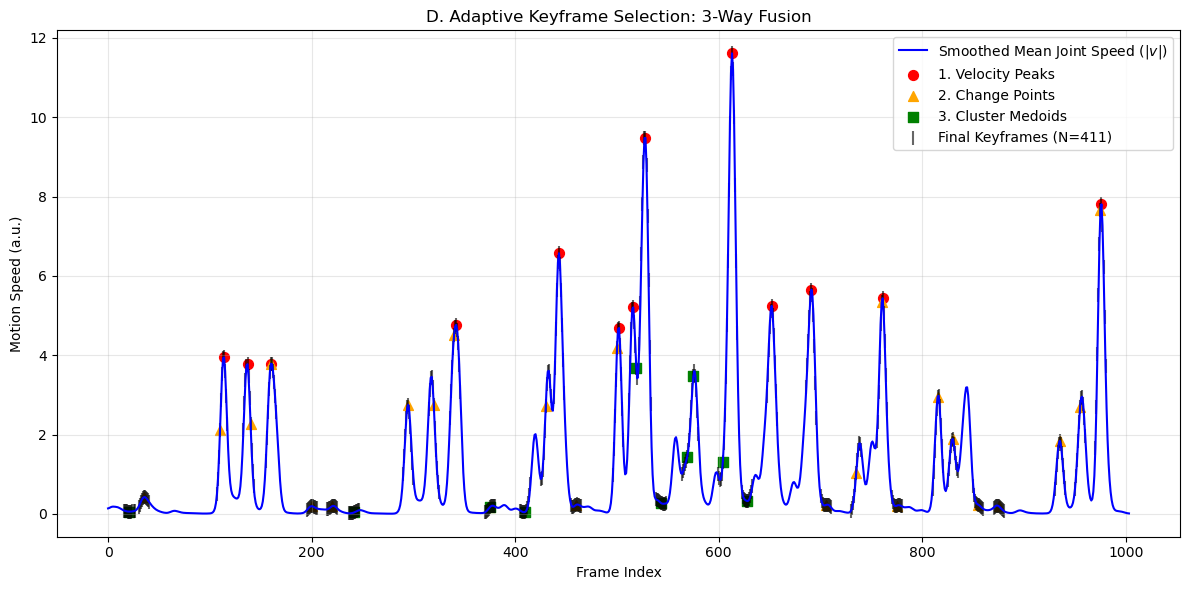

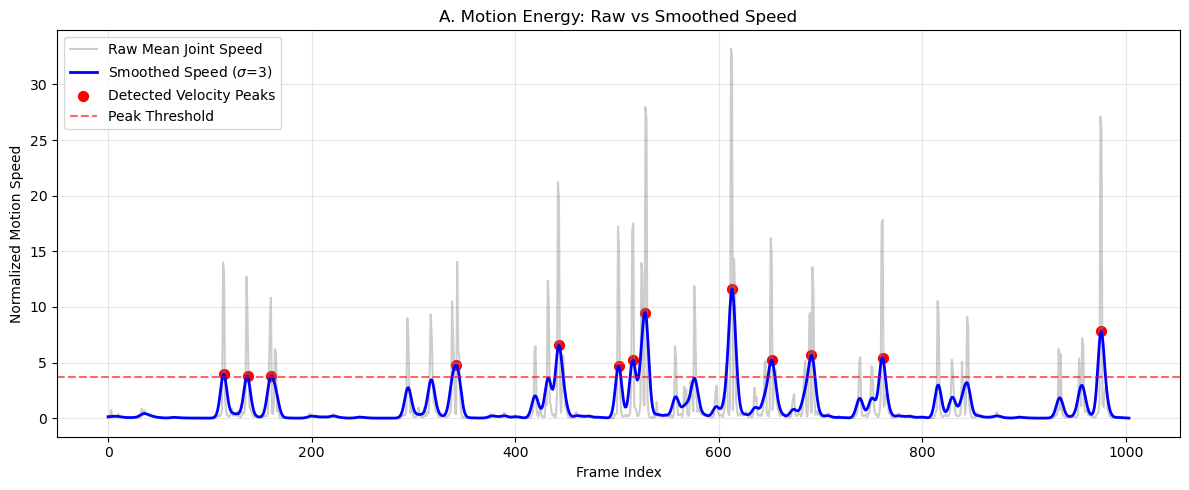

Processing videos:  93%|█████████▎| 14/15 [04:20<00:30, 30.50s/it]

✅ Saved 411 keyframes → /home/jovyan/data/processed/KorvaiAdavu2.mp4

▶ Processing Thattadavu3.mp4


W0000 00:00:1761489491.140267   17366 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1761489491.216521   17377 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


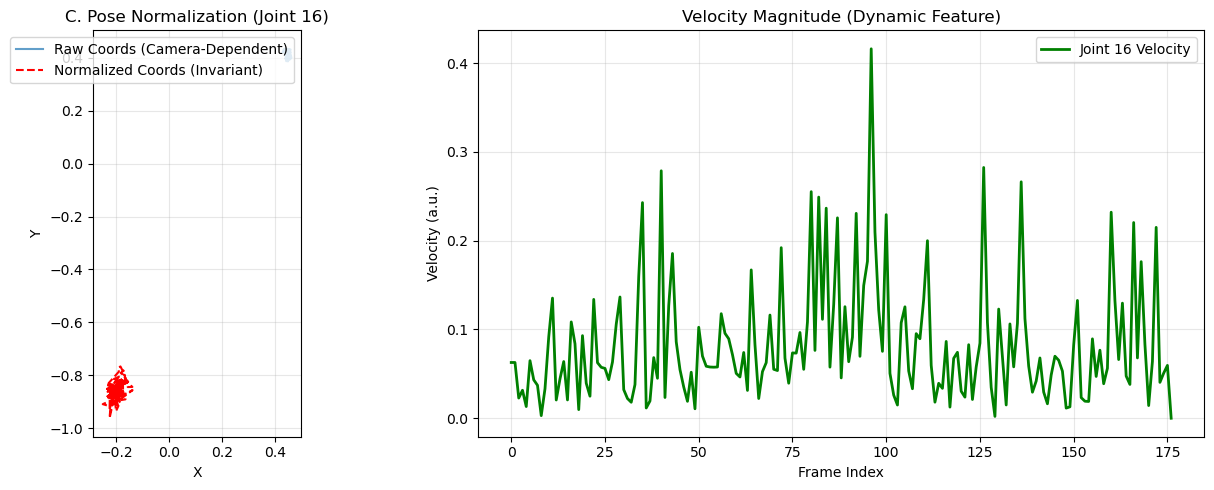

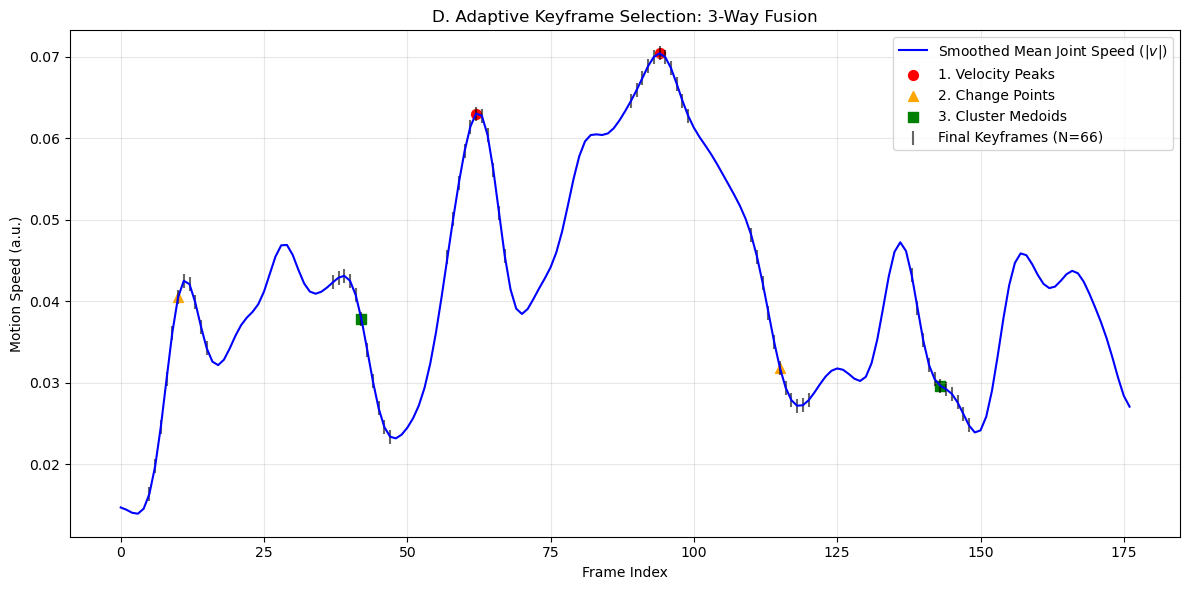

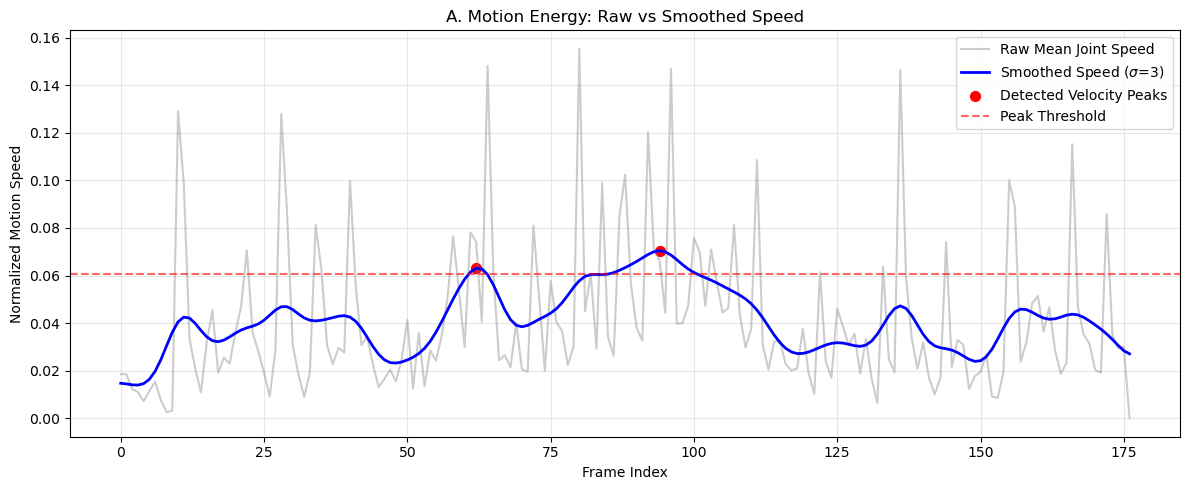

Processing videos: 100%|██████████| 15/15 [04:32<00:00, 18.17s/it]

✅ Saved 66 keyframes → /home/jovyan/data/processed/Thattadavu3.mp4


In [31]:
# ============================================================
# STEP 4 — MAIN PIPELINE (Local / Hugging Face Compatible)
# ============================================================
import os
import cv2
import json
import numpy as np
from tqdm import tqdm
import mediapipe as mp

# ------------------
# CONFIG
# ------------------
CONFIG = {
    "output_dir": "/home/jovyan/data/processed",
    "fps_target": 4,
    "pose_conf_thresh": 0.3,
    "gaussian_sigma": 3,
    "peak_alpha": 1.5,
    "min_peak_distance": 5,
    "ruptures_penalty": 5,
    "min_cluster_size": 10,
    "merge_window": 5,
    "transition_window": 5
}
os.makedirs(CONFIG["output_dir"], exist_ok=True)

# ------------------
# Pose Extraction from Frame Array
# ------------------
def extract_poses_from_array(video_array, fps_target=4, conf_thresh=0.3):
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose(static_image_mode=False, model_complexity=1)

    try:
        frames = video_array["frames"] if isinstance(video_array, dict) else video_array
        T = len(frames)
        frame_interval = max(1, int(round(30 / fps_target)))

        poses, confs, times = [], [], []
        t = 0.0

        for idx, frame in enumerate(frames):
            if frame is None or not isinstance(frame, np.ndarray):
                continue
            if idx % frame_interval != 0:
                continue

            image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = pose.process(image_rgb)

            if results.pose_landmarks:
                landmarks = results.pose_landmarks.landmark
                pose_xy = np.array([[lm.x, lm.y] for lm in landmarks])
                conf = np.array([lm.visibility for lm in landmarks])
            else:
                pose_xy = np.zeros((33, 2))
                conf = np.zeros((33,))

            poses.append(pose_xy)
            confs.append(conf)
            times.append(t)
            t += 1.0 / fps_target
    finally:
        pose.close()

    poses = np.array(poses)
    confs = np.array(confs)
    times = np.array(times)

    # Interpolate low-confidence joints
    poses_filtered = poses.copy()
    for j in range(poses.shape[1]):
        low = confs[:, j] < conf_thresh
        if np.any(low):
            good_idx = np.where(~low)[0]
            if len(good_idx) >= 2:
                poses_filtered[:, j, 0] = np.interp(np.arange(len(poses)), good_idx, poses[good_idx, j, 0])
                poses_filtered[:, j, 1] = np.interp(np.arange(len(poses)), good_idx, poses[good_idx, j, 1])

    return poses_filtered, confs, times, poses

# ------------------
# Process Single Video
# -----# ------------------
# Process Single Video (MODIFIED)
# ------------------
def process_video(video_item):
    vid_name = "unknown_video" # Default name in case 'id' fails
    try:
        vid_name = str(video_item.get("id", f"random_{np.random.randint(1e6)}"))
        
        # --- FIX: Use the correct key 'frames' ---
        video_array_frames = video_item["frames"] 
        # --- End Fix ---

        out_dir = os.path.join(CONFIG["output_dir"], vid_name)
        os.makedirs(out_dir, exist_ok=True)

        print(f"\n▶ Processing {vid_name}")

        poses, confs, times, poses_raw = extract_poses_from_array(
            video_array_frames, # Pass the frames array correctly
            fps_target=CONFIG["fps_target"],
            conf_thresh=CONFIG["pose_conf_thresh"]
        )

        if poses.size == 0:
            print(f"⚠️ Skipped {vid_name}: No valid poses detected.")
            return

        # Normalize & compute features (Pass visualization dir)
        poses_norm, features = normalize_and_compute_features(
            poses, confs, times, out_dir=out_dir, fps_target=CONFIG["fps_target"]
        )
        
        # Detect keyframes (Pass visualization dir and config args)
        keyframes, speed_sm = detect_keyframes(
            poses_norm, times, out_dir=out_dir,
            gaussian_sigma=CONFIG["gaussian_sigma"],
            peak_alpha=CONFIG["peak_alpha"],
            min_peak_distance=CONFIG["min_peak_distance"],
            ruptures_penalty=CONFIG["ruptures_penalty"],
            min_cluster_size=CONFIG["min_cluster_size"],
            merge_window=CONFIG["merge_window"],
            transition_window=CONFIG["transition_window"]
        )

        # Save outputs
        np.save(os.path.join(out_dir, "poses_raw.npy"), poses_raw)
        np.save(os.path.join(out_dir, "poses.npy"), poses_norm)
        np.save(os.path.join(out_dir, "features.npy"), features)
        np.save(os.path.join(out_dir, "confs.npy"), confs)
        with open(os.path.join(out_dir, "keyframes.json"), "w") as f:
            json.dump({"keyframes": keyframes, "times": times.tolist(), "fps_target": CONFIG["fps_target"]}, f, indent=2)

        print(f"✅ Saved {len(keyframes)} keyframes → {out_dir}")
        return out_dir

    except KeyError as ke:
         print(f"❌ Error processing video {vid_name}: Missing key {ke}. Check data loading.")
    except Exception as e:
        print(f"❌ Error processing video {vid_name}: {e}")
        import traceback
        traceback.print_exc() # Print full traceback for debugging

# ------------------
# Load & Process Multiple Videos (Local Folder)
# ------------------
VIDEO_DIR = "/home/jovyan/data/raw_videos"
MAX_VIDEOS = 15

# Recursively find all video files
video_files = []
for root, dirs, files in os.walk(VIDEO_DIR):
    for f in files:
        if f.lower().endswith(('.mp4', '.mov', '.avi', '.mkv', '.webm')):
            video_files.append(os.path.join(root, f))

print(f"Found {len(video_files)} video files in {VIDEO_DIR}")

# Load frames into dicts (like HuggingFace dataset)
sample_videos = []
for file_path in tqdm(video_files[:MAX_VIDEOS], desc="Loading videos"):
    cap = cv2.VideoCapture(file_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    sample_videos.append({"frames": frames, "id": os.path.basename(file_path)})

print(f"📦 Loaded {len(sample_videos)} videos. Starting processing...")

# Process each video
for video_item in tqdm(sample_videos, desc="Processing videos"):
    process_video(video_item)


--------------------------------------------------------------------------------
# **LSTM Model Building**
--------------------------------------------------------------------------------


In [33]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 10.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 24.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 23.4 MB/s eta 0:00:00:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.8
    Uninstalling protobuf-4.25.8:
      Successfully uninstalled protobuf-4.25.8
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
    Uninstalling tensorboard-2.19.0:
      Successfully uninstalled tensorboard-2.19.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mediapipe 0.10.21 requires protobuf<5,>=4.25.3, but you have protobuf 6.33

In [34]:
# ============================================================
# STAGE 2 — LSTM-Based Pose Prediction (5→6, 2→7, etc.)
# ============================================================
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error
from numpy.linalg import norm
import matplotlib.pyplot as plt
import random

2025-10-26 14:39:56.479451: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [44]:
# -------------------------------
# CONFIG
# -------------------------------
SEQ_LEN = 5           # number of input frames
TARGET_LEN = 1        # predict next frame
EPOCHS = 50
BATCH_SIZE = 16
MODEL_SAVE_PATH = "/home/jovyan/models/lstm_pose_predictor.keras"
PROCESSED_DATA_DIR = "/home/jovyan/data/processed"  # ⚡ use processed local poses
MAX_VIDEOS = 15       # limit to first 15 videos for quick testing

# -------------------------------
# Load all processed pose files
# -------------------------------
def load_all_pose_sequences(data_dir=PROCESSED_DATA_DIR, max_videos=None):
    sequences = []
    if not os.path.exists(data_dir):
        print(f"⚠️ Processed data directory {data_dir} not found!")
        return sequences

    video_dirs = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
    if max_videos:
        video_dirs = video_dirs[:max_videos]
        print(f"⚙️ Using only {len(video_dirs)} videos for quick LSTM training.")

    for vid in video_dirs:
        pose_path = os.path.join(data_dir, vid, "poses.npy")
        if os.path.exists(pose_path):
            poses = np.load(pose_path)  # [T, 33, 2]
            if len(poses) > SEQ_LEN + TARGET_LEN:
                sequences.append(poses)
        else:
            print(f"⚠️ Skipping {vid}: poses.npy not found.")
    return sequences

# -------------------------------
# Prepare sliding-window dataset
# -------------------------------
def create_sliding_windows(sequences, seq_len=SEQ_LEN, target_len=TARGET_LEN):
    X, y = [], []
    for seq in sequences:
        T = len(seq)
        for i in range(T - seq_len - target_len + 1):
            X.append(seq[i:i+seq_len])       # input frames
            y.append(seq[i+seq_len:i+seq_len+target_len])  # target frame
    X, y = np.array(X), np.array(y)
    return X, y

# -------------------------------
# Cosine similarity metric
# -------------------------------
from numpy.linalg import norm
def cosine_similarity(a, b):
    a_flat, b_flat = a.reshape(len(a), -1), b.reshape(len(b), -1)
    sims = [np.dot(a_flat[i], b_flat[i]) / (norm(a_flat[i]) * norm(b_flat[i]) + 1e-8) for i in range(len(a))]
    return np.mean(sims)


In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed
import numpy as np

# -------------------------------\n",
# Build LSTM model (CORRECTED)\n",
# -------------------------------\n",
def build_lstm_model(input_shape):
    """
    Builds an LSTM model to predict the next single pose.
    input_shape: (SEQ_LEN, num_features), e.g., (5, 66)
    """
    # input_shape is now (SEQ_LEN, num_features=66)
    num_features = input_shape[1]

    model = Sequential([
        # Input shape expected by LSTM is (batch_size, timesteps, features)
        # Keras automatically handles the batch_size, so we provide (timesteps, features)
        LSTM(256, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        # Last LSTM layer should NOT return sequences if we predict only the next step
        LSTM(128, return_sequences=False),
        Dropout(0.3),
        # Dense layer predicts the flattened features for the *single* next pose
        Dense(num_features)
    ])
    model.compile(optimizer="adam", loss="mse")
    print(f"✅ LSTM model built. Input shape: {input_shape}, Output shape: ({num_features})")
    return model


In [46]:
# -------------------------------
# Training phase
# -------------------------------
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

def train_lstm_model():
    print("📥 Loading pose sequences...")
    sequences = load_all_pose_sequences(PROCESSED_DATA_DIR, max_videos=MAX_VIDEOS)
    if not sequences:
        print("❌ No sequences found. Please check processed data directory.")
        return

    # -------------------------------
    # Create sliding-window dataset
    # -------------------------------
    X, y = create_sliding_windows(sequences, SEQ_LEN, TARGET_LEN)

    num_joints, num_coords = X.shape[2], X.shape[3]
    print(f"⚙️ Sliding windows created: X={X.shape}, y={y.shape}")

    # Flatten X and y for LSTM input/output
    X_flat = X.reshape(X.shape[0], SEQ_LEN, num_joints * num_coords)
    y_flat = y.reshape(y.shape[0], TARGET_LEN, num_joints * num_coords)

    print(f"✅ Flattened dataset: X_flat={X_flat.shape}, y_flat={y_flat.shape}")

    # -------------------------------
    # Build LSTM model
    # -------------------------------
    model = build_lstm_model((SEQ_LEN, X_flat.shape[2]))
    model.summary()

    checkpoint = ModelCheckpoint(MODEL_SAVE_PATH, monitor="val_loss", save_best_only=True, verbose=1)
    early_stop = EarlyStopping(patience=10, restore_best_weights=True)

    # -------------------------------
    # Training
    # -------------------------------
    print("🚀 Training LSTM model on GPU...")
    history = model.fit(
        X_flat, y_flat,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        callbacks=[checkpoint, early_stop],
        verbose=1
    )

    # -------------------------------
    # Evaluate on last 100 sequences
    # -------------------------------
    eval_size = min(100, len(X_flat))
    val_pred = model.predict(X_flat[-eval_size:])
    mse = mean_squared_error(y_flat[-eval_size:].reshape(-1), val_pred.reshape(-1))
    cos = cosine_similarity(y_flat[-eval_size:], val_pred)

    print(f"\n📊 Validation MSE: {mse:.6f}")
    print(f"📊 Cosine Similarity: {cos:.6f}")

    # -------------------------------
    # Plot training/validation loss
    # -------------------------------
    plt.figure(figsize=(8,5))
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title("LSTM Pose Prediction Training")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


--------------------------------------------------------------------------------
# **Pose Generation**
--------------------------------------------------------------------------------


In [1]:
# -------------------------------\n",
# Generation / Choreography (Local / GPU)\n",
# -------------------------------\n",
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import mediapipe as mp # <-- ADDED IMPORT

# ---
# NEW HELPER FUNCTION TO DRAW STICKMAN
# ---
# Define MediaPipe connections for stick figure
MP_POSE_CONNECTIONS = mp.solutions.pose.POSE_CONNECTIONS

def plot_stick_figure(pose_2d, ax, title=""):
    """Plots a single 2D pose (33, 2) as a stick figure on a given plt.Axes."""
    ax.clear()
    ax.set_title(title)
    
    # MediaPipe poses are [x, y] normalized.
    # We assume the input pose_2d is already normalized.
    x = pose_2d[:, 0]
    y = pose_2d[:, 1]
    
    ax.scatter(x, y, s=10, c='red') # Plot joints as red dots
    
    # Plot connections (bones)
    if MP_POSE_CONNECTIONS:
        for (start_idx, end_idx) in MP_POSE_CONNECTIONS:
            # Check if joints are valid (within the 33 landmarks)
            if start_idx < len(x) and end_idx < len(x):
                ax.plot([x[start_idx], x[end_idx]],
                        [y[start_idx], y[end_idx]], 'c-') # Cyan color for bones
                        
    ax.set_xlabel('X (Normalized)')
    ax.set_ylabel('Y (Normalized)')
    ax.set_aspect('equal', 'box')
    ax.invert_yaxis() # Invert y-axis to match image coordinates
    ax.grid(True, alpha=0.3)
# ---
# END HELPER FUNCTION
# ---


def generate_future_poses_online(video_name, poses, n_future=10):
    """
    Generate future poses using trained LSTM model.

    Args:
        video_name (str): Name/ID of the video.
        poses (np.array): Normalized poses of shape [T, 33, 2].
        n_future (int): Number of future frames to generate.

    Returns:
        generated (np.array): Predicted future poses of shape [n_future, 33, 2].
    """
    print(f"\n🎬 Generating {n_future} poses for {video_name}...")

    if len(poses) < SEQ_LEN:
        print(f"❌ Not enough frames to start generation (need {SEQ_LEN}, got {len(poses)}).")
        return np.array([]) # Return empty array

    # Load trained LSTM model
    # Use compile=False and recompile manually to avoid legacy .h5 error
    try:
        model = load_model(MODEL_SAVE_PATH, compile=False)
        model.compile(optimizer="adam", loss="mse") # Recompile
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        print("Please ensure the model file exists and was trained correctly.")
        return np.array([])

    # ---
    # 🔴 CRITICAL BUG FIX: Use the LAST frames, not the first
    # ---
    # OLD: input_seq = poses[:SEQ_LEN].copy()
    input_seq = poses[-SEQ_LEN:].copy() # NEW: Use last SEQ_LEN frames
    # ---
    # END BUG FIX
    # ---

    generated = []
    
    # Get shape for reshaping
    num_features = input_seq.shape[1] * input_seq.shape[2] # 33 * 2 = 66
    
    for _ in range(n_future):
        # Flatten input for LSTM: (SEQ_LEN, 33, 2) -> (1, SEQ_LEN, 66)
        inp = input_seq.reshape(1, SEQ_LEN, num_features)
        
        # Predict next frame (will be shape (1, 66))
        pred = model.predict(inp, verbose=0)
        
        # Reshape prediction back to pose format: (1, 66) -> (33, 2)
        next_pose = pred.reshape(input_seq.shape[1], input_seq.shape[2])
        generated.append(next_pose)

        # Slide window:
        # 1. Drop the oldest frame (index 0)
        # 2. Add the new predicted frame (next_pose) to the end
        # We add a new dimension to next_pose to make it (1, 33, 2) for concatenation
        input_seq = np.concatenate([input_seq[1:], next_pose[None, ...]], axis=0)

    generated = np.array(generated)
    if generated.size == 0:
        print("❌ Generation failed to produce poses.")
        return np.array([])
        
    print(f"✅ Generated poses shape: {generated.shape}")

    # ----------------------------------------------------
    # REPLACED VISUALIZATION: Plot stick figures
    # ----------------------------------------------------
    
    # Create a 1x2 plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot the last INPUT frame (the seed) on the left
    last_input_pose = poses[-1]
    plot_stick_figure(last_input_pose, ax1, title=f"Last Input Pose (Frame {len(poses)-1})")
    
    # Plot the first GENERATED frame on the right
    first_generated_pose = generated[0]
    plot_stick_figure(first_generated_pose, ax2, title="First Generated Pose (Prediction)")
    
    plt.suptitle(f"Pose Generation for {video_name}")
    plt.tight_layout()
    plt.show()

    return generated

ModuleNotFoundError: No module named 'tensorflow'

📥 Loading pose sequences...
⚙️ Using only 15 videos for quick LSTM training.
⚠️ Skipping THATTIMETTUADAVU1.1.mp4: poses.npy not found.
⚠️ Skipping ThaThaiThaHa5.mp4: poses.npy not found.
⚠️ Skipping Thattadavu1.3.mp4: poses.npy not found.
⚠️ Skipping Thattadavu1.mp4: poses.npy not found.
⚠️ Skipping Thattadavu2.5.mp4: poses.npy not found.
⚠️ Skipping ThattiMettuAdavu4.1.mp4: poses.npy not found.
⚠️ Skipping ThattimettuAdavu2.mp4: poses.npy not found.
⚙️ Sliding windows created: X=(2740, 5, 33, 2), y=(2740, 1, 33, 2)
✅ Flattened dataset: X_flat=(2740, 5, 66), y_flat=(2740, 1, 66)
✅ LSTM model built. Input shape: (5, 66), Output shape: (66)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 5, 256)         │       330,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 66)             │         8,514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 536,386 (2.05 MB)

 Trainable params: 536,386 (2.05 MB)

 Non-trainable params: 0 (0.00 B)

🚀 Training LSTM model on GPU...
Epoch 1/50
152/155 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 15.2806
Epoch 1: val_loss improved from None to 0.79438, saving model to /home/jovyan/models/lstm_pose_predictor.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 10.0813 - val_loss: 0.7944
Epoch 2/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.1574
Epoch 2: val_loss did not improve from 0.79438
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.4597 - val_loss: 1.1346
Epoch 3/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.4204
Epoch 3: val_loss did not improve from 0.79438
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.3977 - val_loss: 1.2003
Epoch 4/50
152/155 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 10.3991
Epoch 4: val_loss did not improve from 0.79438
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.3545 - val_loss: 0.9568
Epoch 5/50
149/155 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 16.0966
Epoch 5: val_loss did not improve from 0.79438
155/155 ━━━━━━━━━━━━━━━━━━━━ 

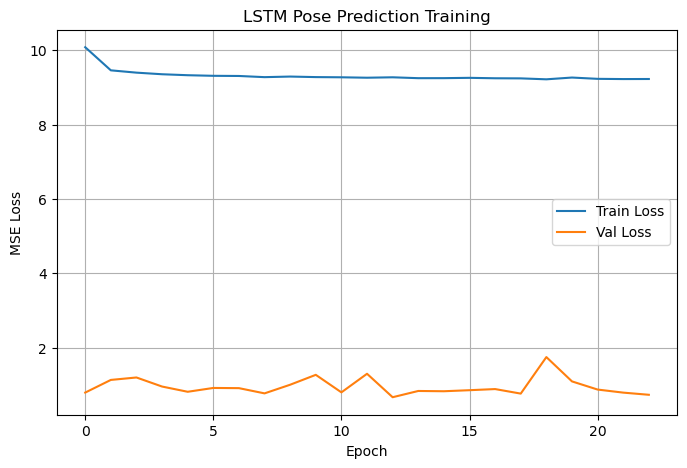


🎬 Generating poses for local videos...
⚙️ Using only 15 videos for quick LSTM training.
⚠️ Skipping THATTIMETTUADAVU1.1.mp4: poses.npy not found.
⚠️ Skipping ThaThaiThaHa5.mp4: poses.npy not found.
⚠️ Skipping Thattadavu1.3.mp4: poses.npy not found.
⚠️ Skipping Thattadavu1.mp4: poses.npy not found.
⚠️ Skipping Thattadavu2.5.mp4: poses.npy not found.
⚠️ Skipping ThattiMettuAdavu4.1.mp4: poses.npy not found.
⚠️ Skipping ThattimettuAdavu2.mp4: poses.npy not found.

🎬 Generating 10 poses for local_video_1...
✅ Generated poses shape: (10, 33, 2)


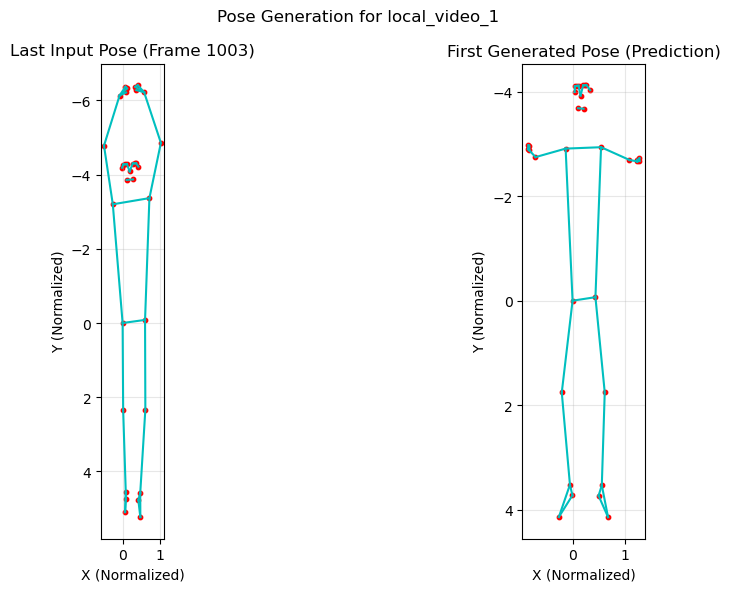


🎬 Generating 10 poses for local_video_2...
✅ Generated poses shape: (10, 33, 2)


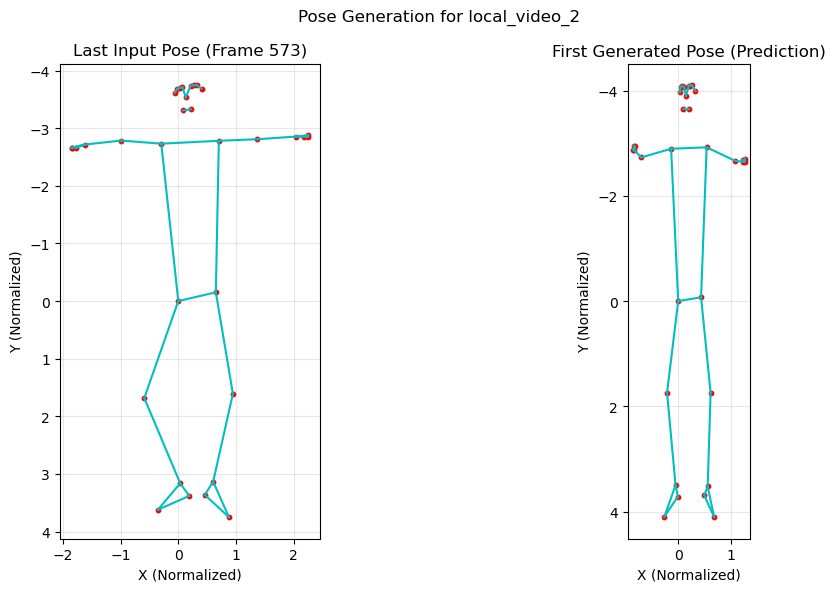


🎬 Generating 10 poses for local_video_3...
✅ Generated poses shape: (10, 33, 2)


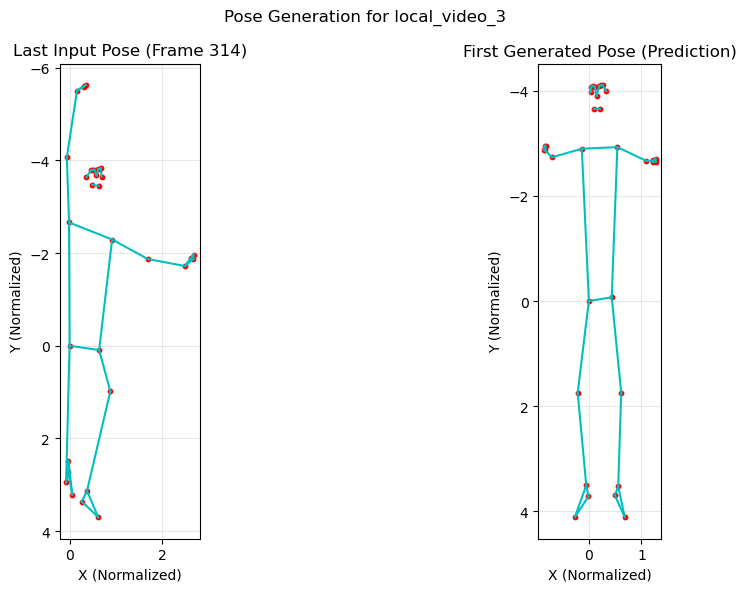


🎬 Generating 10 poses for local_video_4...
✅ Generated poses shape: (10, 33, 2)


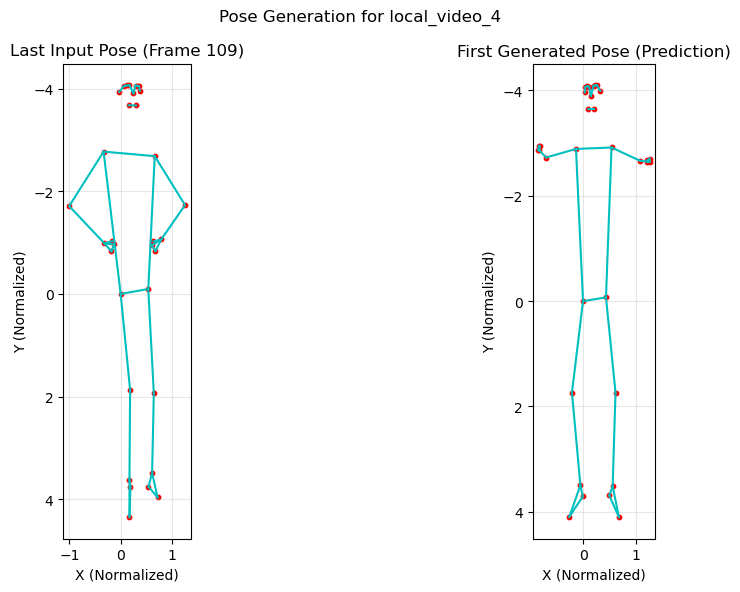


🎬 Generating 10 poses for local_video_5...
✅ Generated poses shape: (10, 33, 2)


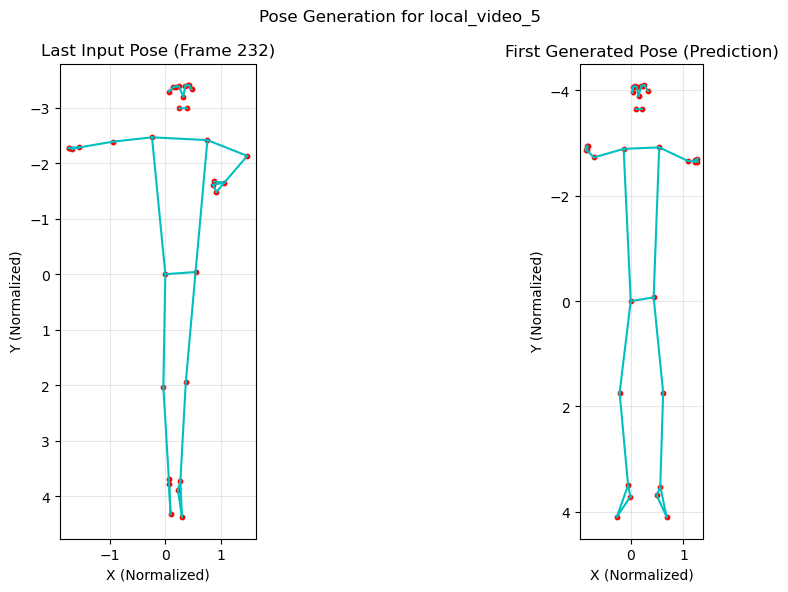


🎬 Generating 10 poses for local_video_6...
✅ Generated poses shape: (10, 33, 2)


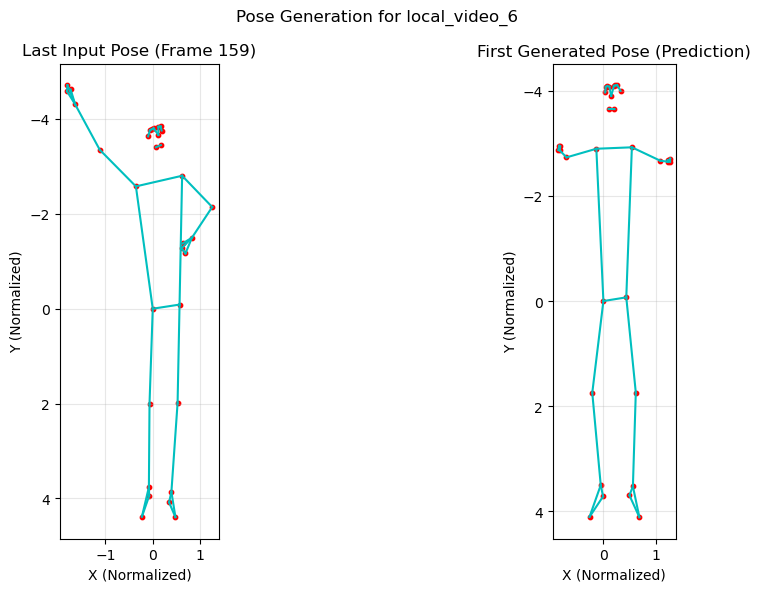


🎬 Generating 10 poses for local_video_7...
✅ Generated poses shape: (10, 33, 2)


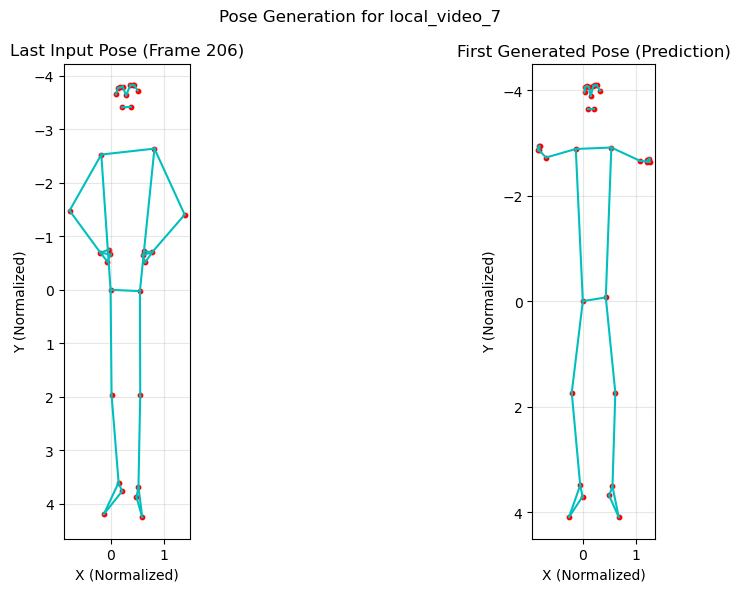


🎬 Generating 10 poses for local_video_8...
✅ Generated poses shape: (10, 33, 2)


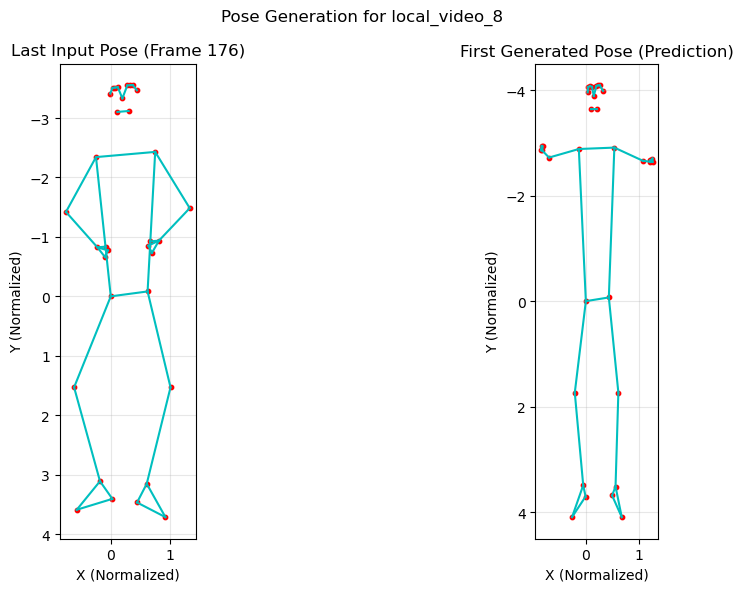

In [51]:
# -------------------------------
# Entrypoint (Local / Saturn GPU)
# -------------------------------
if __name__ == "__main__":
    os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)

    # Step 1: Train LSTM model on local processed data
    train_lstm_model()

    # Step 2: Generate poses for a few local videos
    print("\n🎬 Generating poses for local videos...")

    # Load local processed pose sequences
    sequences = load_all_pose_sequences(PROCESSED_DATA_DIR, max_videos=MAX_VIDEOS)

    for idx, poses in enumerate(sequences):
        video_name = f"local_video_{idx+1}"

        # Ensure poses are normalized (should already be from processing, but safe)
        if poses.ndim != 3 or poses.shape[1:] != (33, 2):
            print(f"⚠️ Skipping {video_name}: unexpected shape {poses.shape}")
            continue

        # Generate future poses
        generate_future_poses_online(video_name, poses, n_future=10)
